# Gem cells lineage both sex - Seurat analysis

In [1]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)
# source('G_lib_TFacts.r')

my_colors = c('#c466b0', 
               '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')

def_colors = list( reds = my_colors[13:length(my_colors) ],
                 yellows = my_colors[7:12],
                 blues = my_colors[2:6],
                 greys = c('#e8e8e8', '#b5b5b5', '#a6a6a6') )

colors = c(my_colors, 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))

col_dot = c('grey90',  brewer.pal(n = 9, name = 'Reds')[7])

downsample_data = function(anndataO, var = 'annotated_clusters', N=200){
    samples = list()
    for (cl in unique(anndataO@meta.data[,var]) ){
        cells = colnames(anndataO)[ anndataO@meta.data[,var] == cl ]
        samples[[cl]] = cells
        if( length(cells) > N )
            samples[[cl]] = sample(cells, size = N, replace = F)
    }
    anndataOF = subset(anndataO, cells = unlist(samples))
    
    gene_counts = tabulate(anndataOF@assays$RNA@counts@i + 1)
    anndataOF = subset(anndataOF, features = names(gene_counts)[ gene_counts > 3 ] )
    
    return(anndataOF)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /home/jovyan/my-conda-envs/R_Seurat3/lib/libblas.so.3.8.0
LAPACK: /home/jovyan/my-conda-envs/R_Seurat3/lib/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.5        Seurat_3.

In [3]:
markers = list( 
                PGCs= c('POU5F1', 'NANOG', 'NANOS3', 'SOX17', 'IFITM1', 'XIST'),
                GCs = c('DAZL', 'DDX4', 'MAEL'),
                oogenesis = c('ZGLP1'), 
                RA = c('STRA8', 'ESX1'), 
                meiosis = c('MEIKIN', 'SYCP1', 'MEIOC'), 
                oocyte = c('FIGLA','OOSP2', 'GDF9', 'ZP3', 'FOXO3','SOHLH1', 'SOHLH2', 'NOBOX', 'LHX8', 'YBX2', 'TSC2'),
                pre_spermatogonia=c('MORC1', 'PIWIL4', 'NKAPL', 'VCX3A'),
                cycling = c('CDK1', 'MKI67')    
)
unlist(markers)[ which(duplicated(unlist(markers))) ]

named character(0)

# Load processed object

In [4]:
anndataO = readRDS('/nfs/team292/lg18/with_valentina/germcells.rds')

# Plots supplementary

## metadata

In [5]:
levels(Idents(anndataO) )

[1] "PGC"               "PGC_mitotic"       "GC_mitotic"       
[4] "oogonia_STRA8"     "oogonia_meiosis"   "oocyte"           
[7] "pre-spermatogonia"

In [6]:
Idents(anndataO) = factor(Idents(anndataO), levels = c('PGC' ,'PGC_mitotic','GC_mitotic','oogonia_STRA8','oogonia_meiosis','oocyte','pre-spermatogonia') )
anndataO$annotated_clusters = Idents(anndataO)

anndataO$sex_annot = as.character(anndataO$annotated_clusters)
anndataO$sex_annot[ anndataO$sex == 'male' ] = paste0(anndataO$annotated_clusters[ anndataO$sex == 'male' ], ' - male')
anndataO$sex_annot[ anndataO$sex != 'male' ] = paste0(anndataO$annotated_clusters[ anndataO$sex != 'male' ], ' - female')

anndataO = subset(anndataO, cells = colnames(anndataO)[ anndataO$sex_annot != 'oogonia_meiosis - male' ] )

In [7]:
mycolors = c(def_colors$yellows[1:3], def_colors$reds[3:1], def_colors$blues[1], def_colors$greys)

In [8]:
mycolors

[1] "#7b9e99" "#91bd80" "#bdb380" "#d9abb7" "#edb7b7" "#e08b8b" "#779eed"
 [8] "#e8e8e8" "#b5b5b5" "#a6a6a6"

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


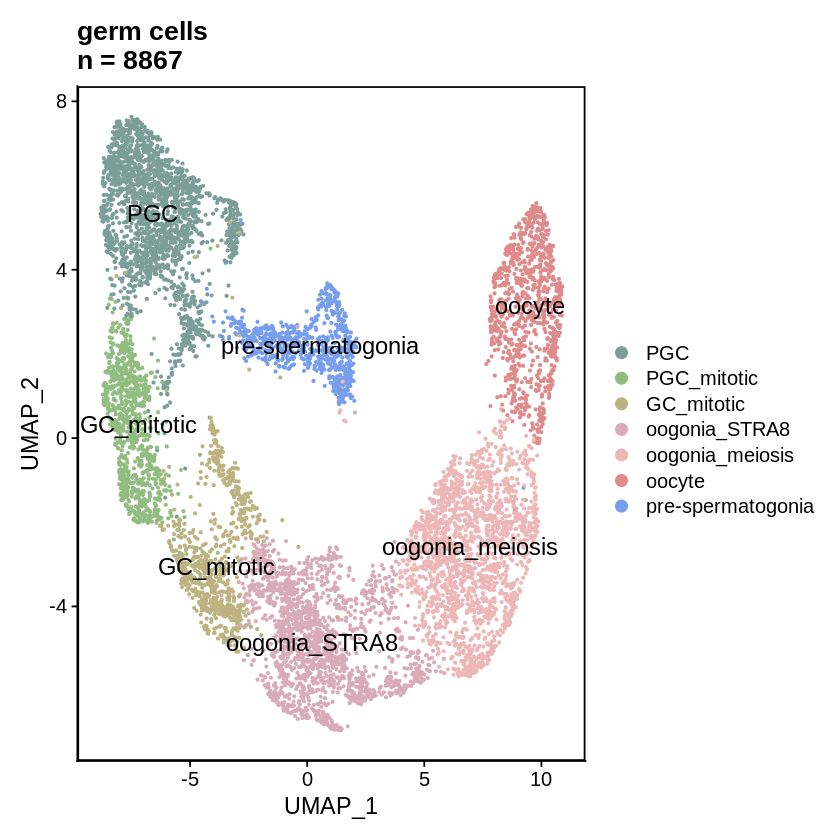

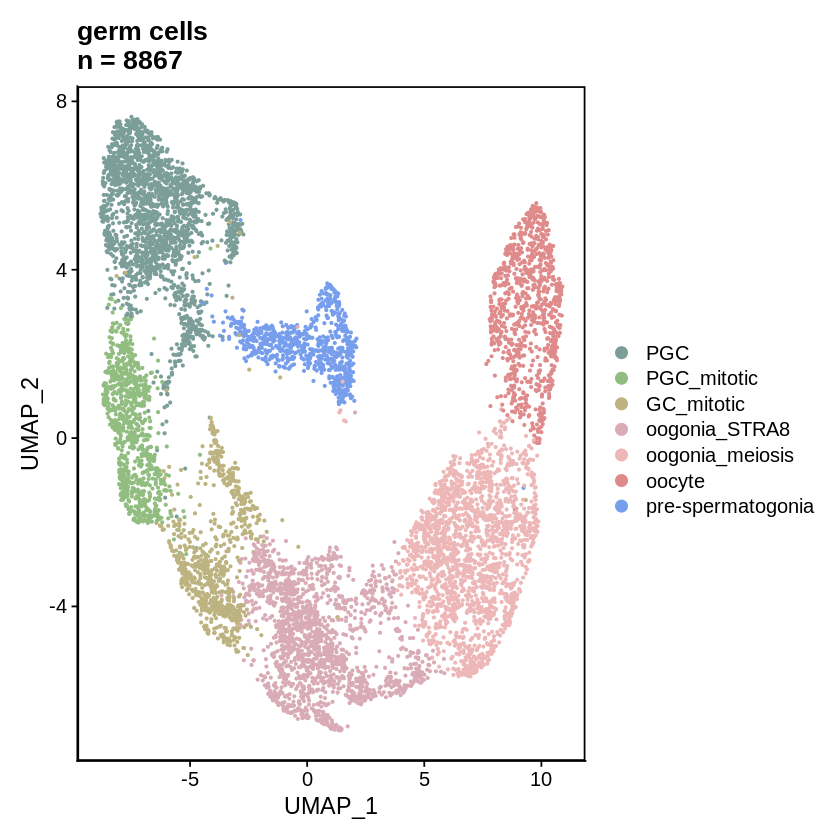

In [9]:
DimPlot(anndataO, reduction = "umap", label = T, pt.size =0.5, label.size = 5,
        cols = mycolors) + 
        ggtitle(paste0('germ cells\nn = ', ncol(anndataO)))  + 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))

ggsave(filename = paste0('figures-germcells/0_F1_umap_annotated.pdf'), dpi = 300, width = 6.5, height = 5)
DimPlot(anndataO, reduction = "umap", label = F, pt.size =0.5, 
        cols = mycolors) + 
        ggtitle(paste0('germ cells\nn = ', ncol(anndataO)))+ 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-germcells/0_F1_umap_annotatedL.pdf'), dpi = 300, width = 6.5, height = 5)

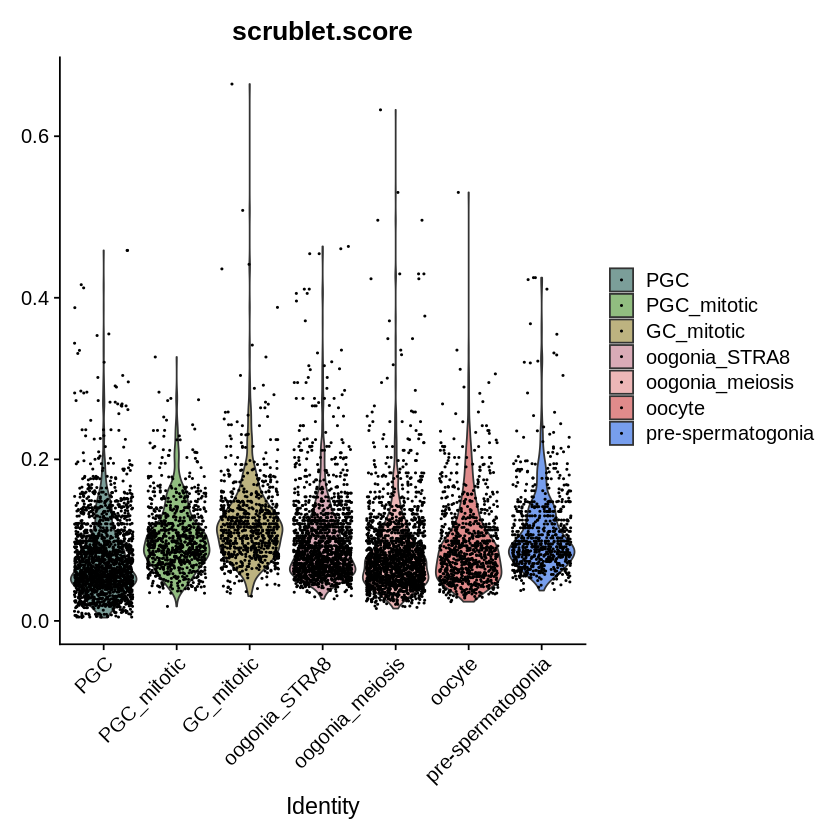

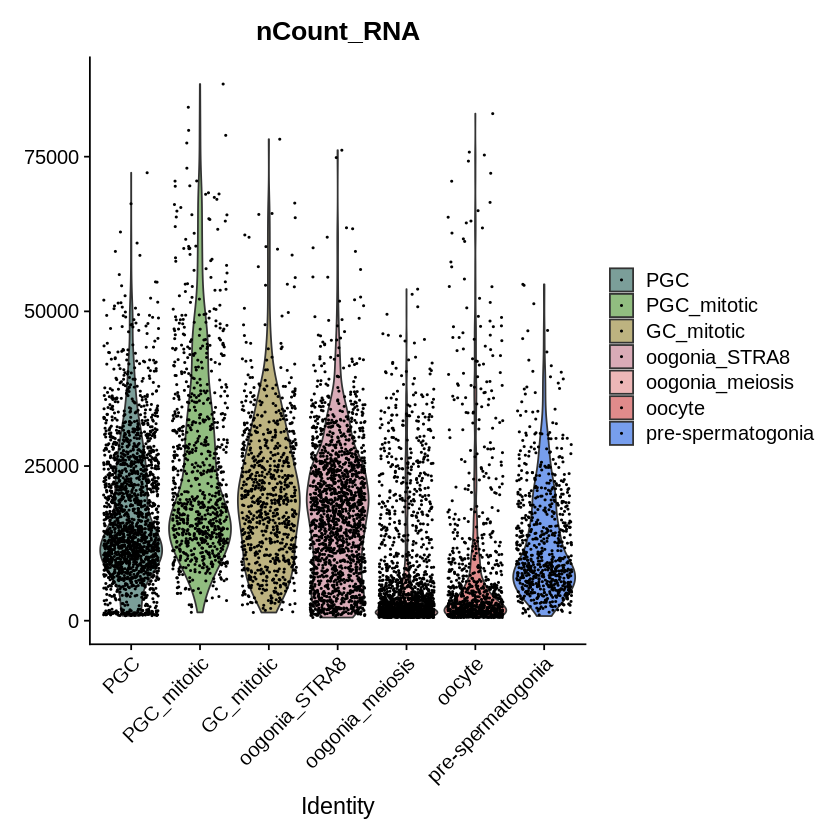

In [10]:
VlnPlot(anndataO, c('scrublet.score'), 
        pt.size = 0.2,
        ncol = 1, 
        cols = mycolors)
ggsave(filename = paste0('figures-germcells/0_FS1_boxplot_scublet.pdf'), dpi = 300, width = 6.5, height = 5)

VlnPlot(anndataO, c('nCount_RNA'), 
        pt.size = 0.2,
        ncol = 1, 
        cols = mycolors)
ggsave(filename = paste0('figures-germcells/0_FS1_boxplot_nCount_RNA.pdf'), dpi = 300, width = 6.5, height = 5)

## Plots

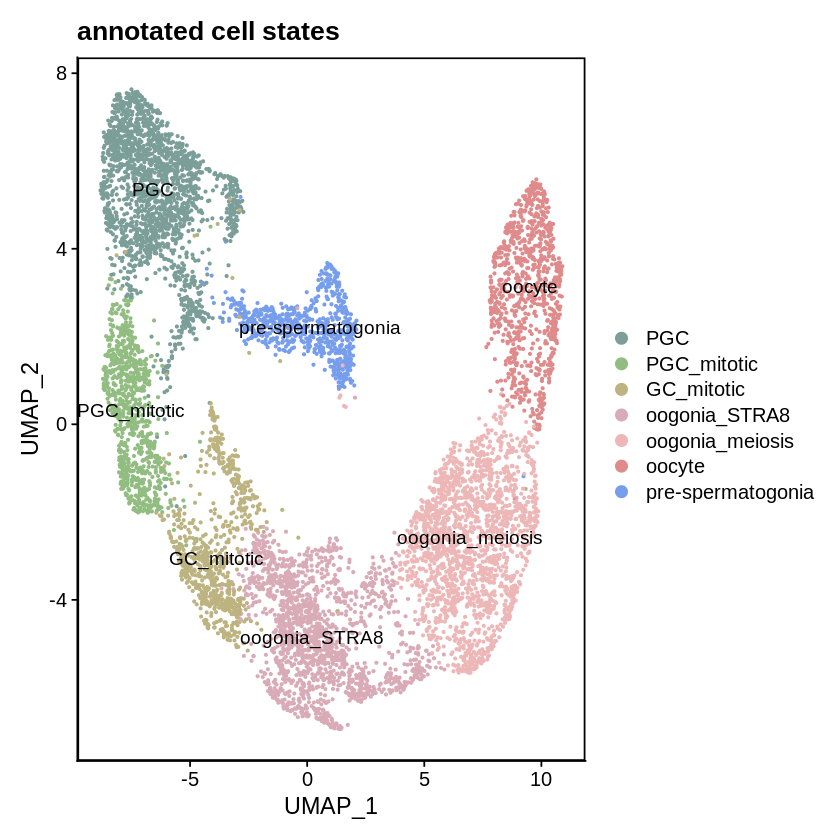

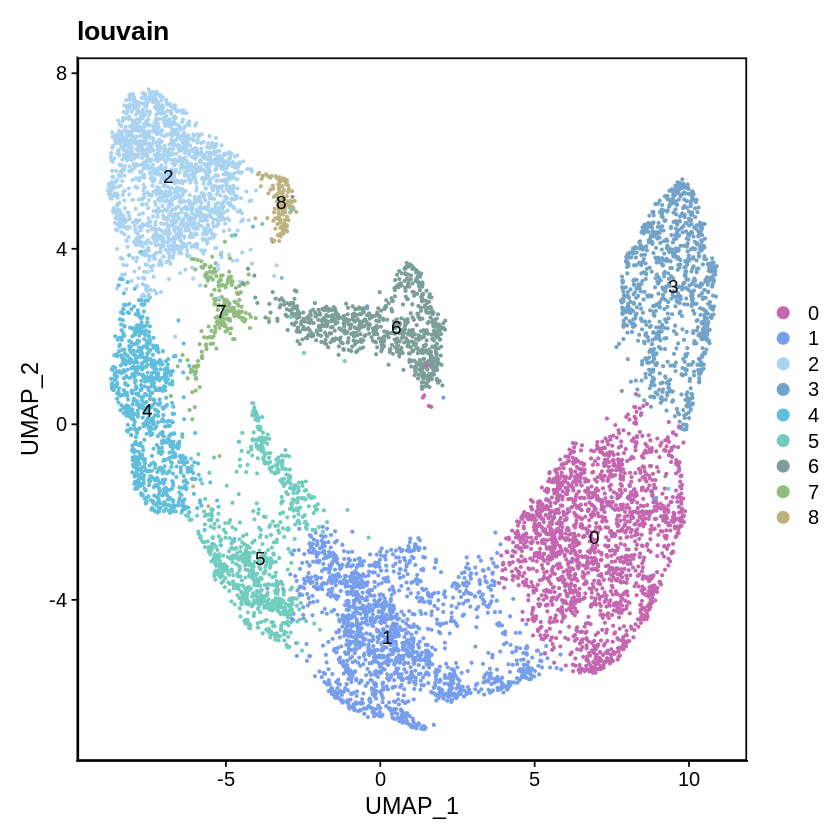

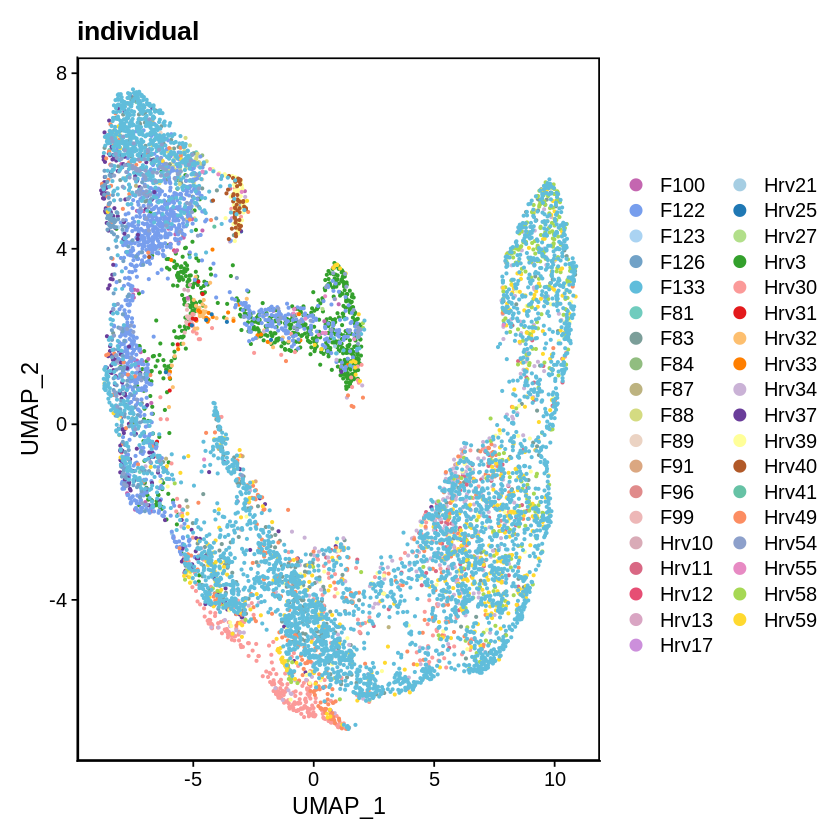

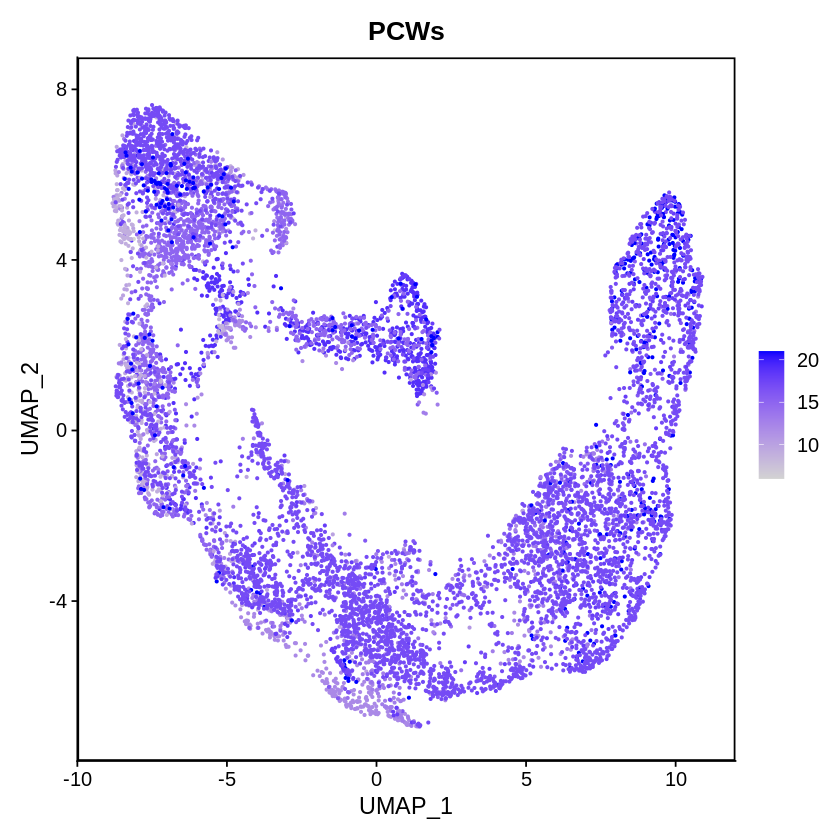

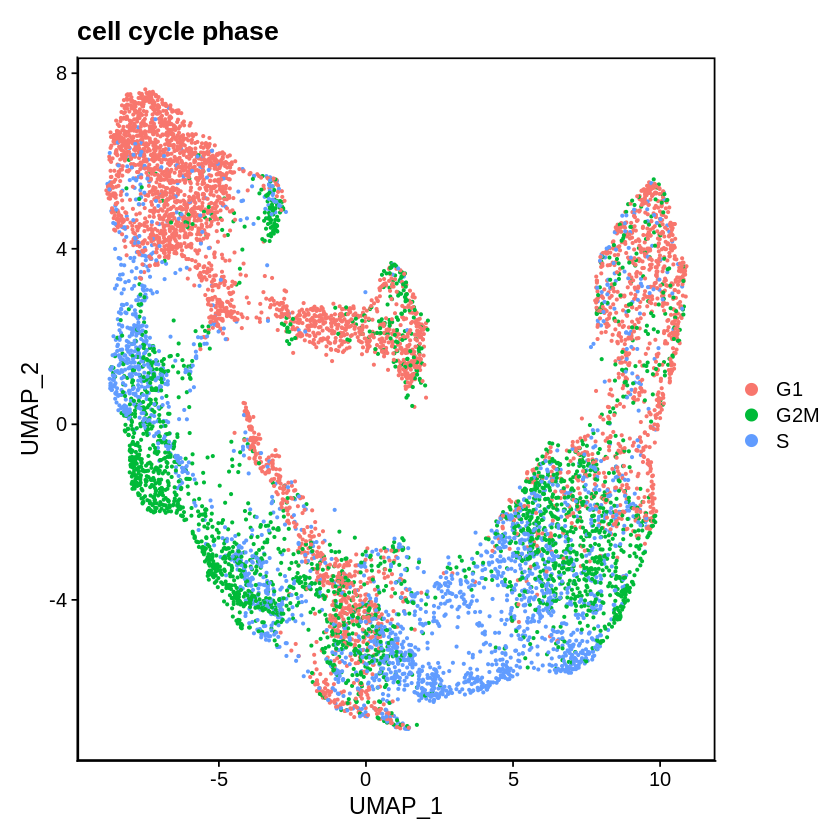

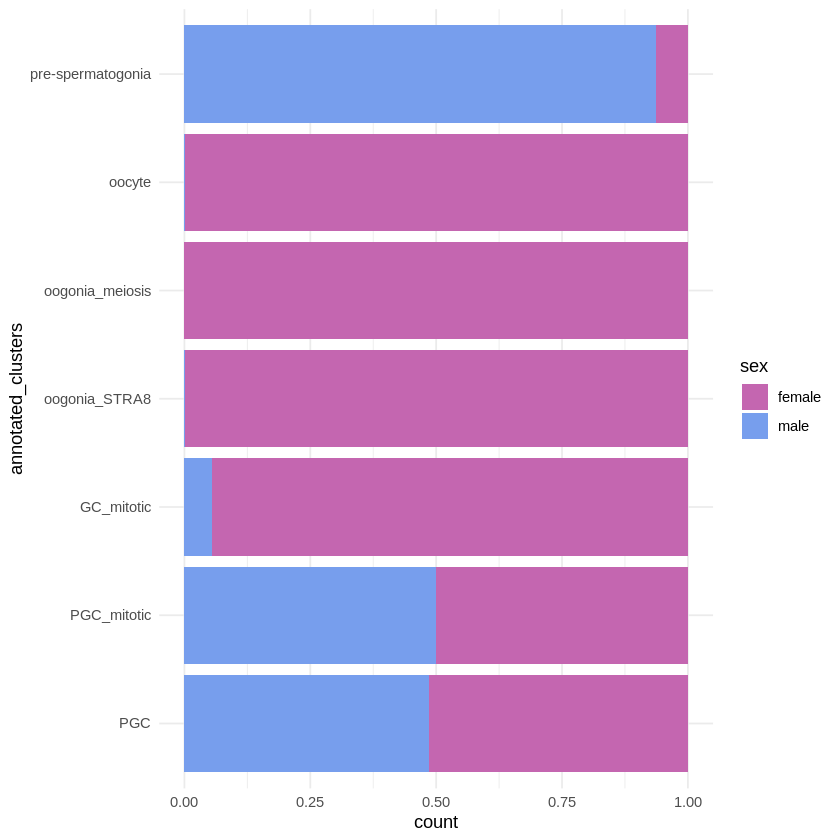

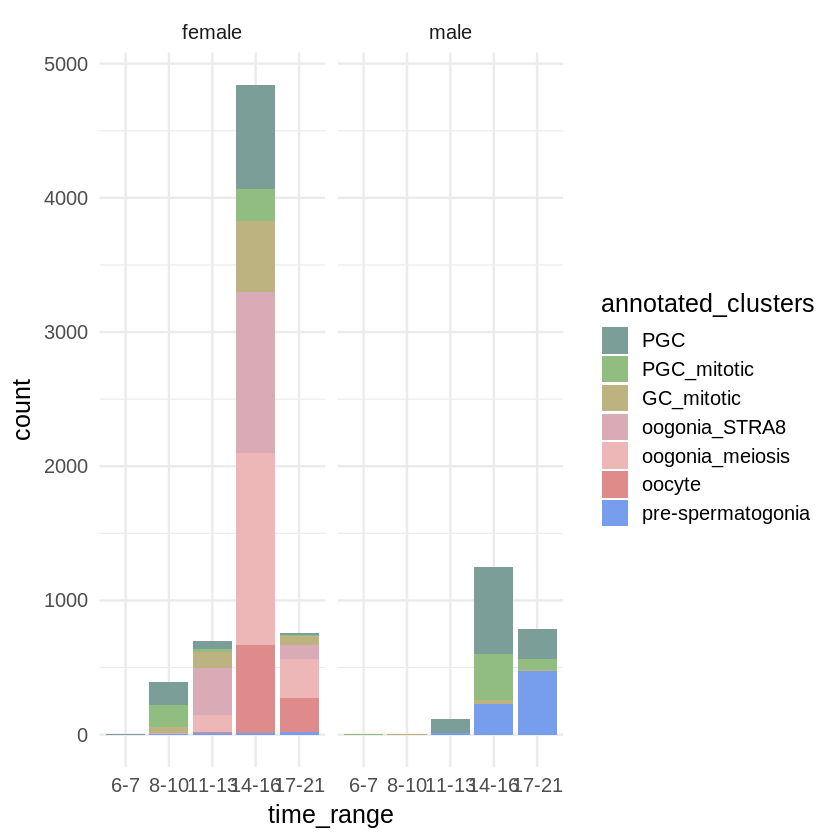

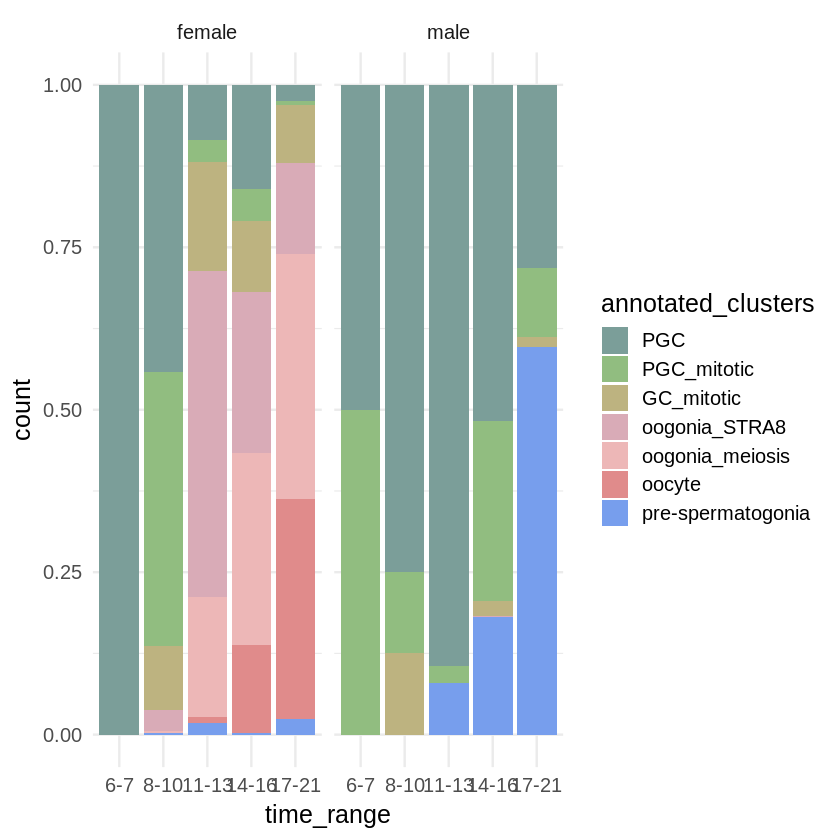

In [11]:
DimPlot(anndataO, reduction = "umap", label = T, pt.size =0.5, 
        cols = mycolors) + 
        ggtitle('annotated cell states') + 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-germcells/0_F1_umap_annotated.pdf'), dpi = 300, width = 6.5, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'seurat_clusters', label = T, cols = colors, pt.size =0.5) + ggtitle('louvain') + 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-germcells/0_FS1_umap_louvain.pdf'), dpi = 300, width = 6.5, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'individual', label = F, cols = colors, pt.size =0.5) + ggtitle('individual')+ 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-germcells/0_FS1_umap_individual.pdf'), dpi = 300, width = 6.5, height = 5)

FeaturePlot(anndataO, reduction = "umap", features = 'PCW', pt.size =0.5) + ggtitle('PCWs')+ 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-germcells/0_FS1_umap_PCWs.pdf'), dpi = 300, width = 6.5, height = 5)

DimPlot(anndataO, reduction = "umap", group.by = 'Phase', pt.size =0.5) + ggtitle('cell cycle phase')+ 
        theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
ggsave(filename = paste0('figures-germcells/0_FS1_umap_cellcyclephase.pdf'), dpi = 300, width = 6.5, height = 5)


ggplot(anndataO@meta.data, aes(x=annotated_clusters, fill = sex) ) + 
    geom_bar(position = 'fill') + coord_flip() + scale_fill_manual(values = my_colors) +
    theme_minimal()
ggsave(filename = paste0('figures-germcells/0_FS1_barplot_sex.pdf'), dpi = 300, width = 6.5, height = 5)


anndataO@meta.data$time_range = '6-7'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 8 ] = '8-10'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 11 ] = '11-13'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 14 ] = '14-16'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >17 ] = '17-21'
anndataO@meta.data$time_range = factor(anndataO@meta.data$time_range, levels = c('6-7', '8-10', '11-13', '14-16', '17-21') )
ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
#     geom_bar(position = 'fill')+
    geom_bar()+
    theme_minimal(15)
ggsave(filename = paste0('figures-germcells/0_FS1_barplot_PCWs_sex.pdf'), dpi = 300, width = 8.5, height = 5)

ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = mycolors) +
    facet_wrap(~sex)+
    geom_bar(position = 'fill')+
    theme_minimal(15)
ggsave(filename = paste0('figures-germcells/0_FS1_barplot_PCWs_sexII.pdf'), dpi = 300, width = 8.5, height = 5)

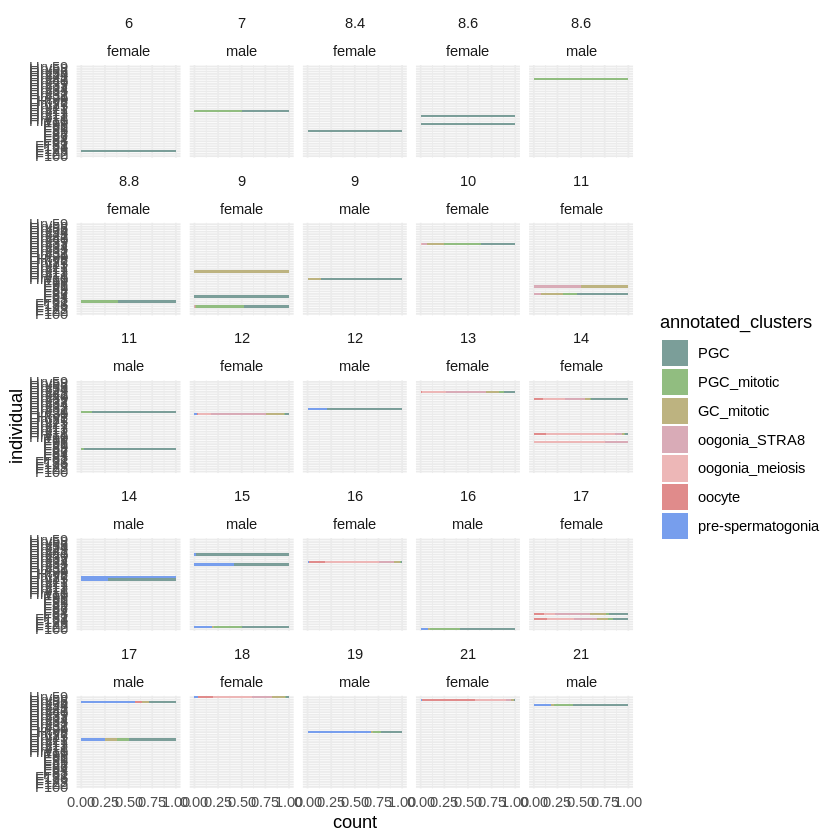

In [12]:
ggplot(anndataO@meta.data, aes(x=individual, fill = annotated_clusters) ) + 
    geom_bar(position = 'fill') + coord_flip() + scale_fill_manual(values = mycolors) +
    facet_wrap(PCW~sex)+
    theme_minimal()


# Known markers

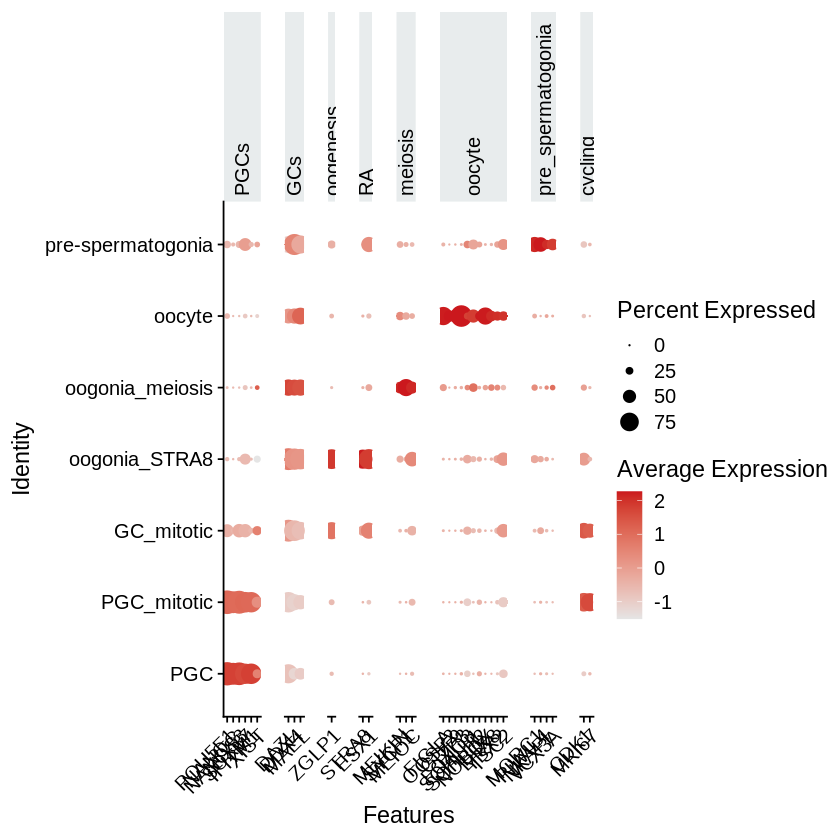

In [13]:
DotPlot(anndataO, features = markers, cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) 
ggsave(filename = paste0('figures-germcells/0_F1_dotplot_markers.pdf'), dpi = 75, height = 5, width = 13)

In [14]:
c2r = colnames(anndataO)[ Idents(anndataO) == 'pre-spermatogonia' & anndataO$sex == 'female']
anndataO = subset(anndataO, cells = colnames(anndataO)[ ! colnames(anndataO) %in% c2r ] )

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



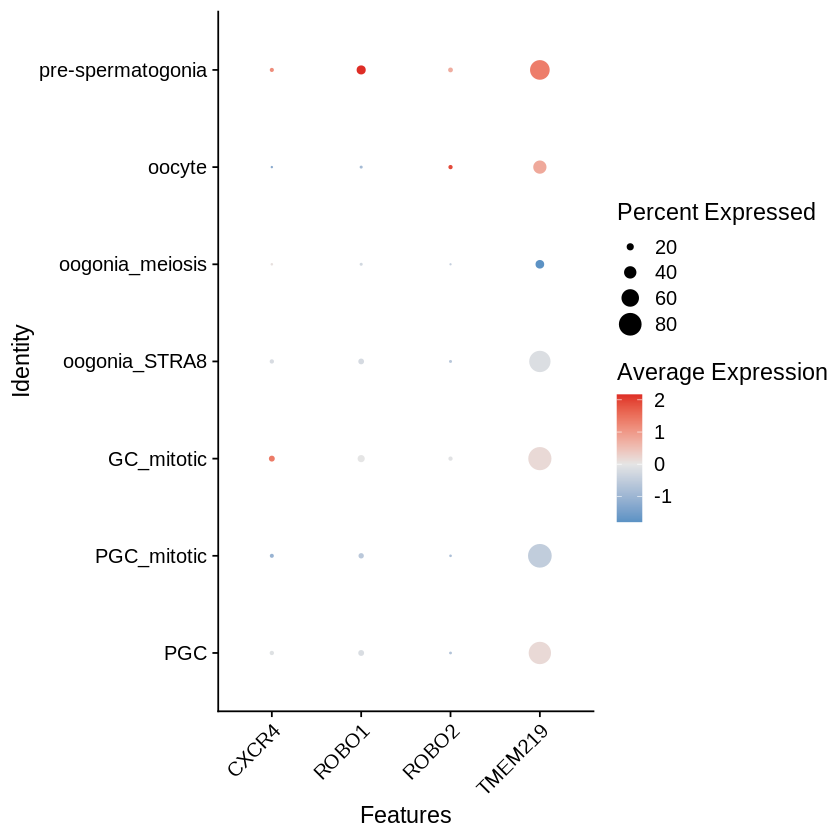

In [15]:
DotPlot(anndataO, features = c('CXCR4', 'ROBO1', 'ROBO2',  'TMEM219')) + RotatedAxis() + 
         scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                              high = brewer.pal(n = 5, name = 'Reds')[4], 
                              mid = 'grey90')
ggsave(filename = paste0('figures-germcells/0_F1_dotplot_sPAX8_ligands.pdf'), dpi = 75, height = 3.5, width = 5)

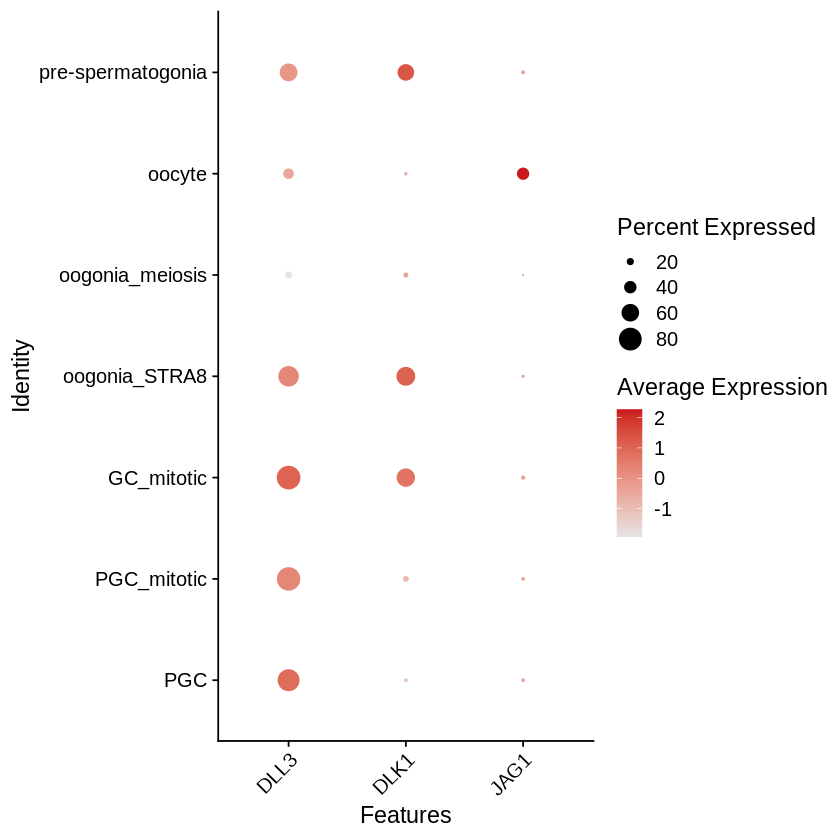

In [21]:
DotPlot(anndataO, features = c('DLL3', 'DLK1', 'JAG1'), cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-germcells/0_F1_dotplot_NOTCHligands.pdf'), dpi = 75, height = 3.5, width = 4.75)

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: CXCR3”


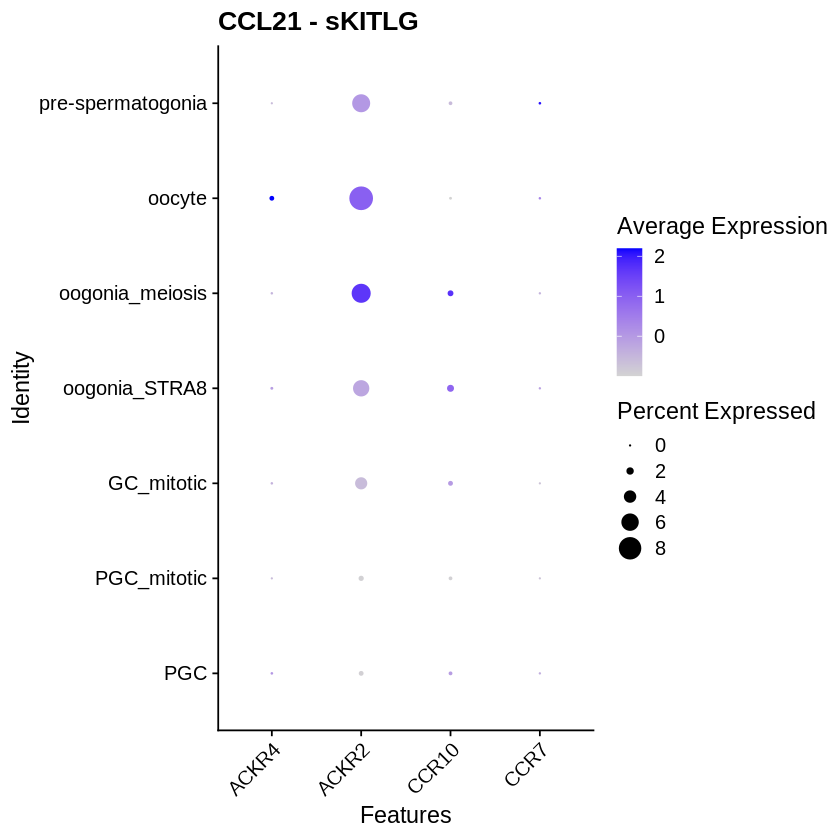

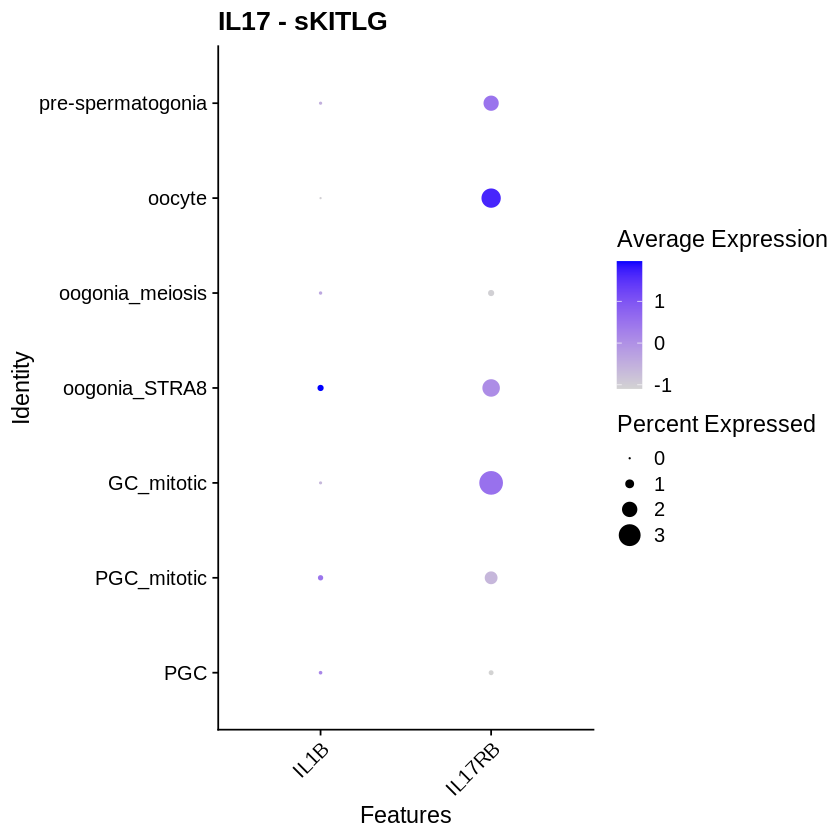

In [17]:
DotPlot(anndataO, features = c('ACKR4', 'ACKR2', 'CCR10', 'CCR7', 'CXCR3')) + RotatedAxis() + ggtitle('CCL21 - sKITLG')
DotPlot(anndataO, features = c('IL1B',  'IL17RB')) + RotatedAxis() + ggtitle('IL17 - sKITLG')

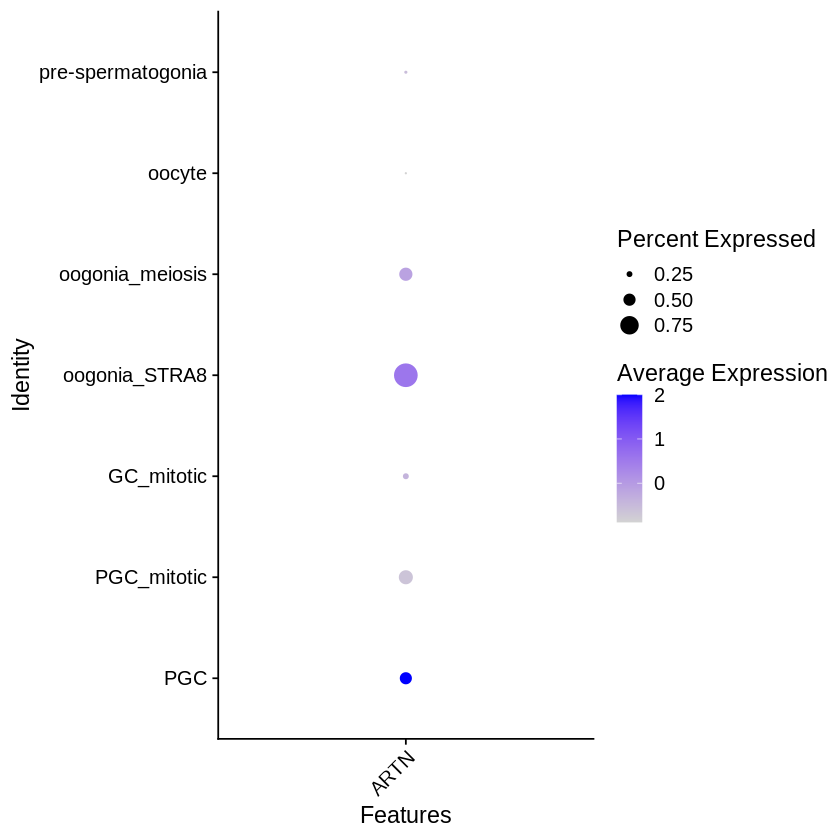

In [18]:
DotPlot(anndataO, features = c('ARTN')) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: CDH14”


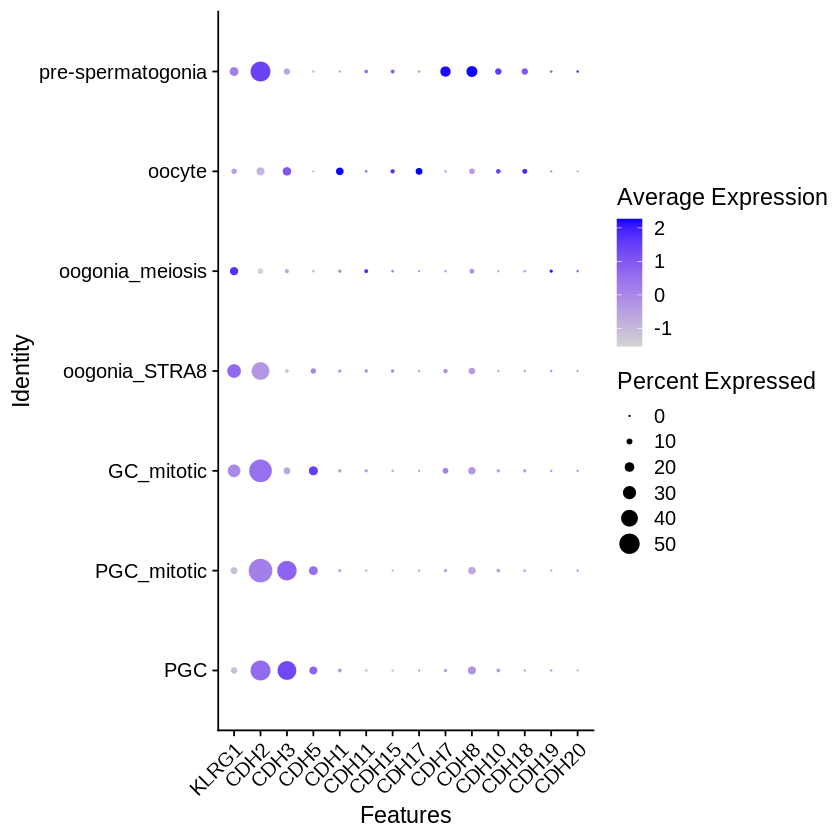

In [19]:
DotPlot(anndataO, features = c('KLRG1', 'CDH2', 'CDH3',  'CDH5',
                               'CDH1', 'CDH11',   'CDH14',  'CDH15',   'CDH17',  
                                 'CDH7','CDH8', 'CDH10',  'CDH18', 'CDH19', 'CDH20' )) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))

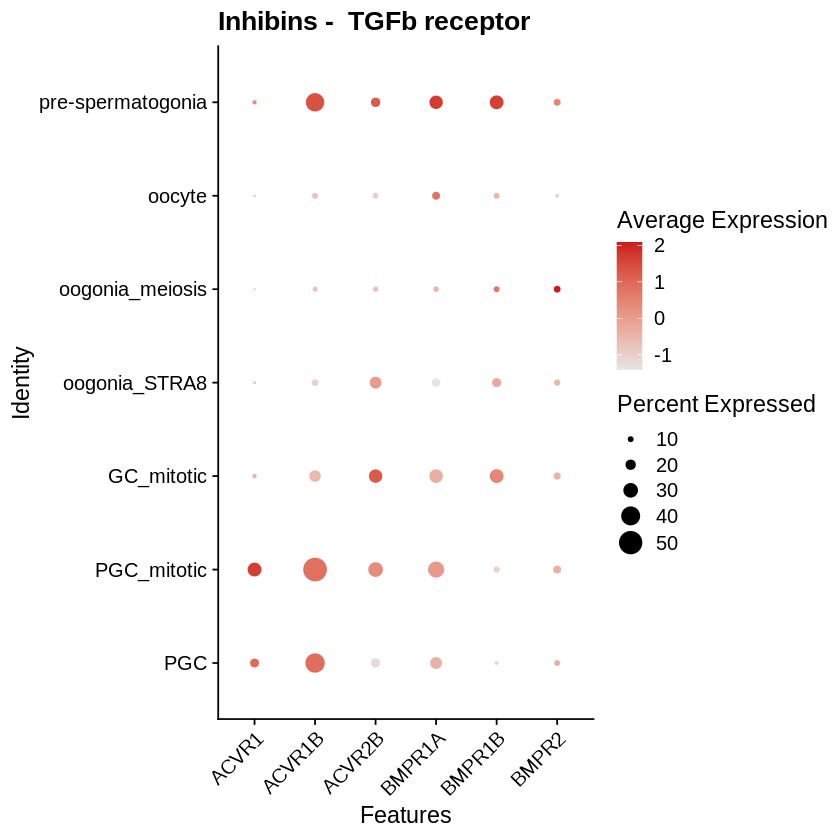

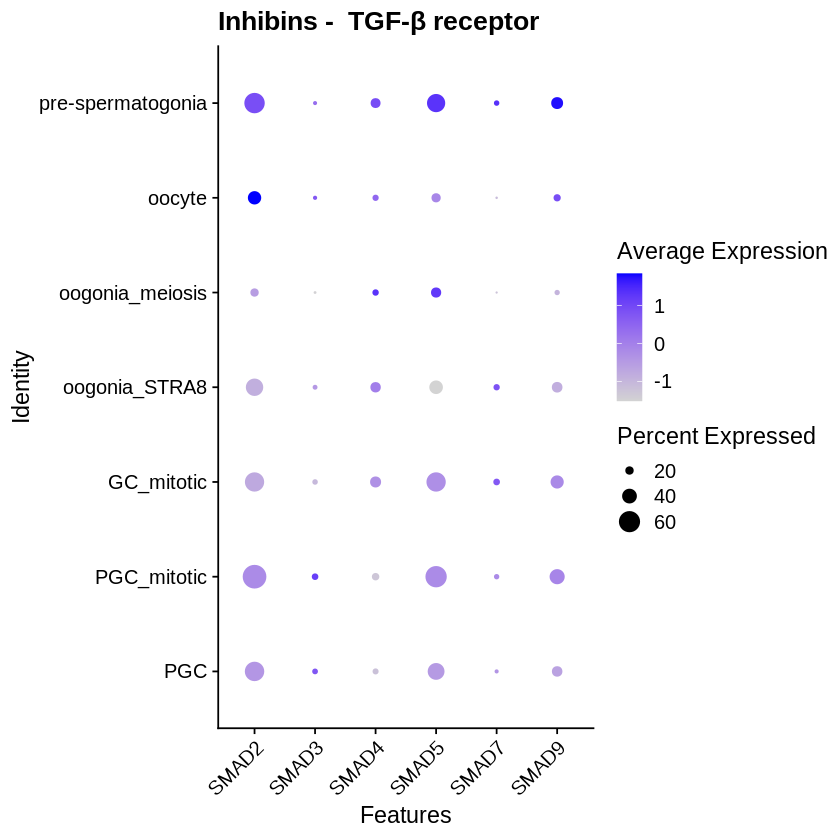

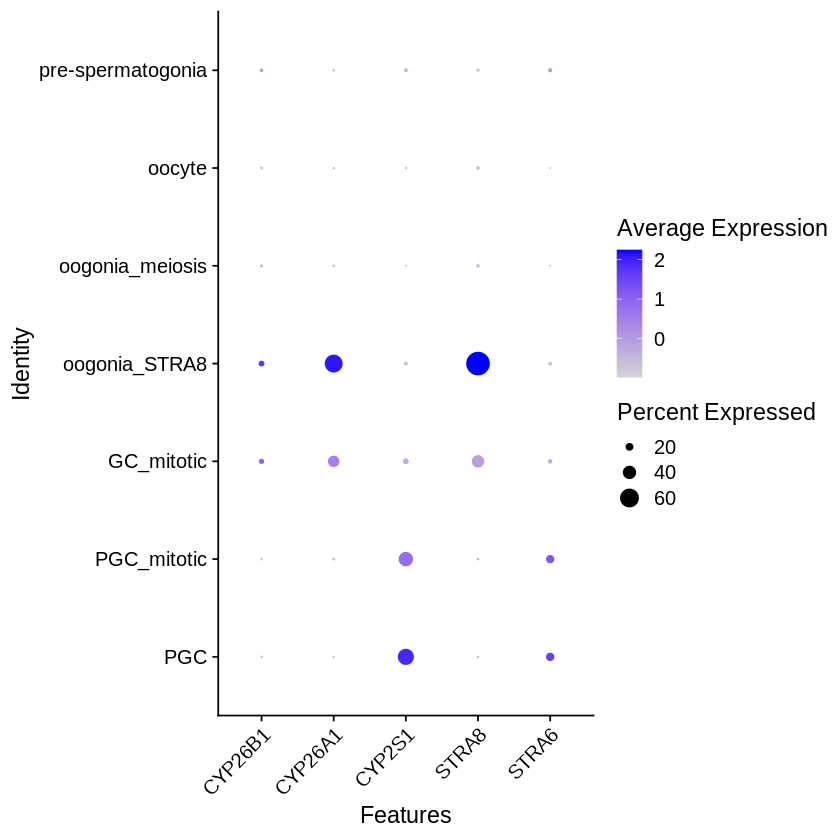

In [20]:
DotPlot(anndataO, features = c('ACVR1','ACVR1B', 'ACVR2B', 'BMPR1A', 'BMPR1B', 'BMPR2'), cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=45, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('Inhibins -  TGFb receptor') 
ggsave(filename = paste0('figures-germcells/0_Fint_dotplot_TGFb.pdf'), dpi = 75, height = 4, width = 5.5)


DotPlot(anndataO, features = c('SMAD2','SMAD3', 'SMAD4', 'SMAD5', 'SMAD7', 'SMAD9')) + RotatedAxis() +  theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('Inhibins -  TGF-β receptor') 


DotPlot(anndataO, features = c('CYP26B1', 'CYP26A1', 'CYP2S1', 'STRA8', 'STRA6')) + RotatedAxis() +  theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) 

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: LINC02763, PATL2ZP2”


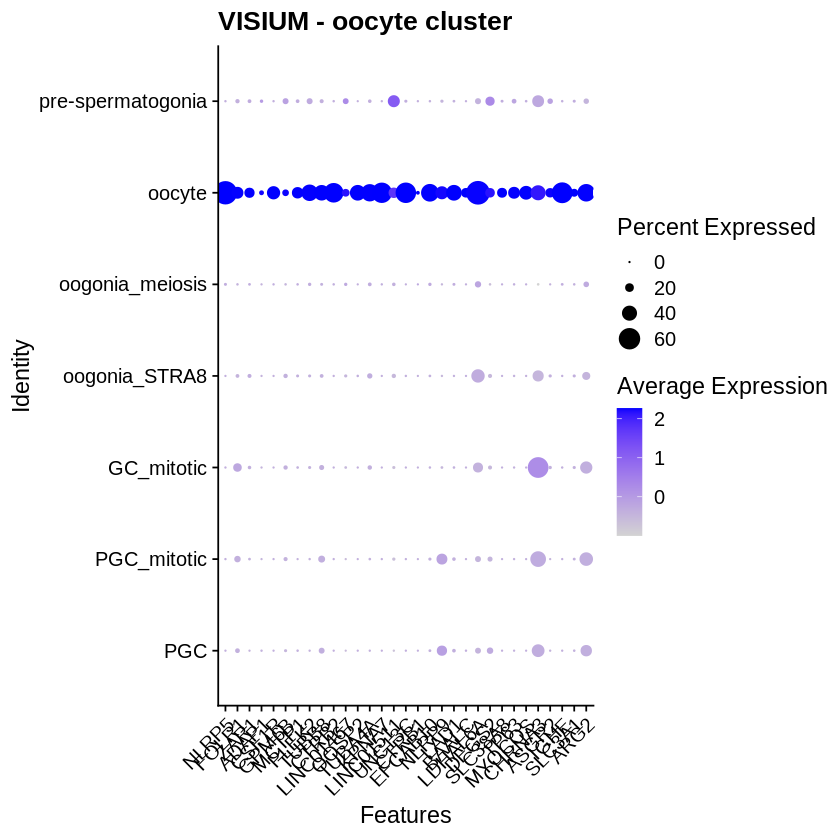

In [21]:
DotPlot(anndataO, features = c('NLRP5',  'FOLR1',  'ZAR1', 'ADAP1',
'CSF1R', 'GPM6B', 'MCTP1', 'PLEK2', 'TUBB8', 'CTRB2', 'LINC01467', 'OOSP2', 
'TUBA4A', 'KPNA7', 'LINC01511', 'UNC13C', 'CTRB1', 'EFCAB10', 'NLRP9', 'LAD1', 'BAALC',
'LDHAL6A', 'DEGS2', 'SLC38A8', 'TP63', 'MYOCOS', 'CHRNA3', 'LINC02763', 'ASGR2', 'PATL2ZP2',
'IGHE', 'SLC3A1', 'ARG2')) + RotatedAxis() +  theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('VISIUM - oocyte cluster') 

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: LINC02763, PATL2ZP2”
Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: FR”


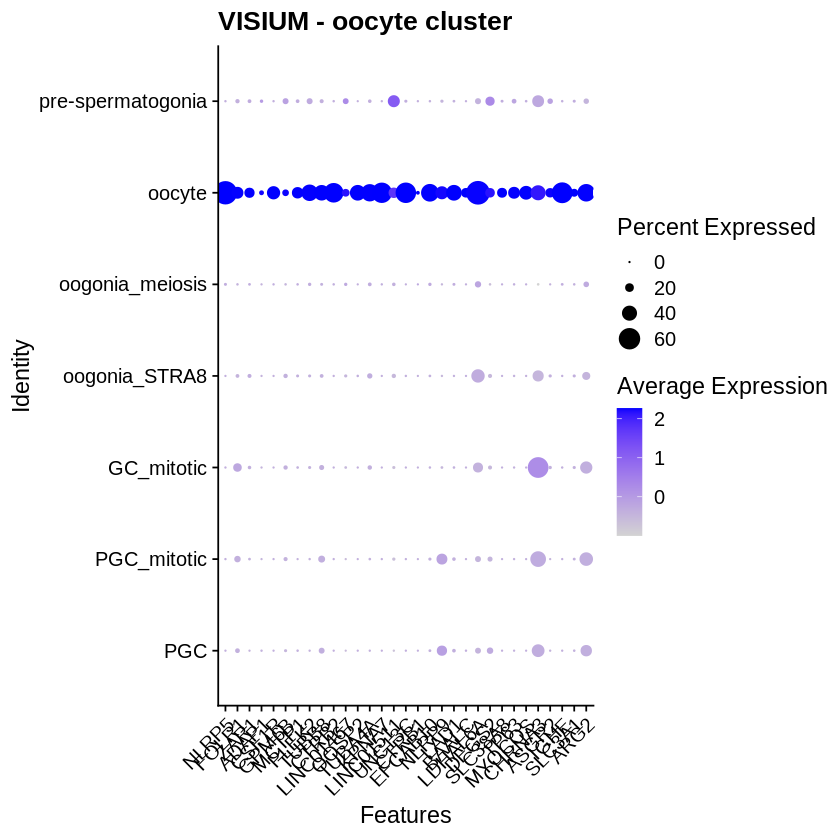

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: FRZBENG”


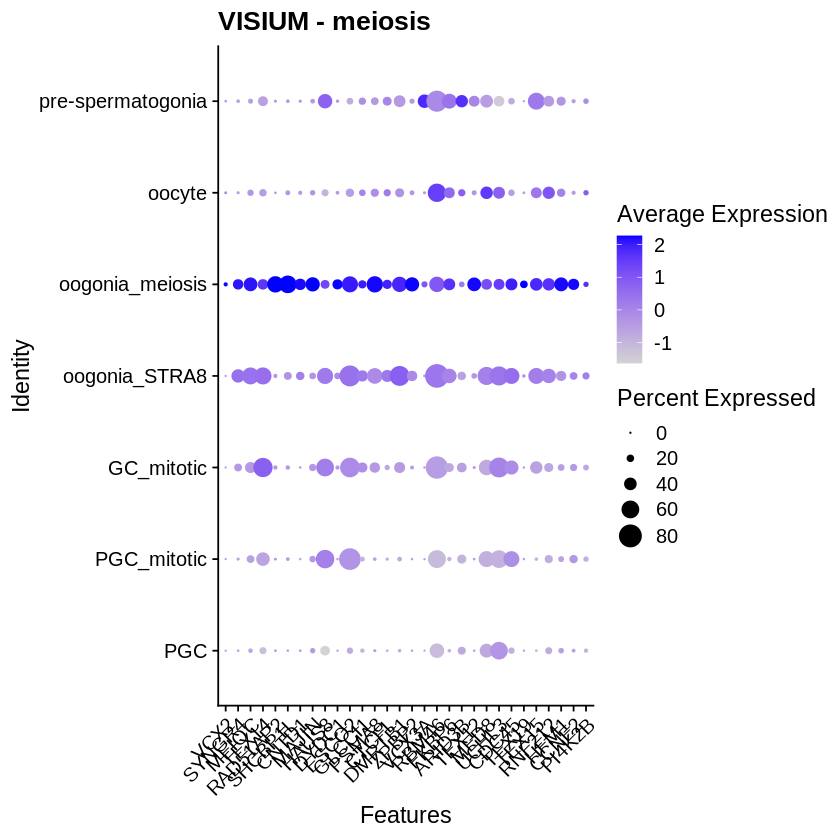

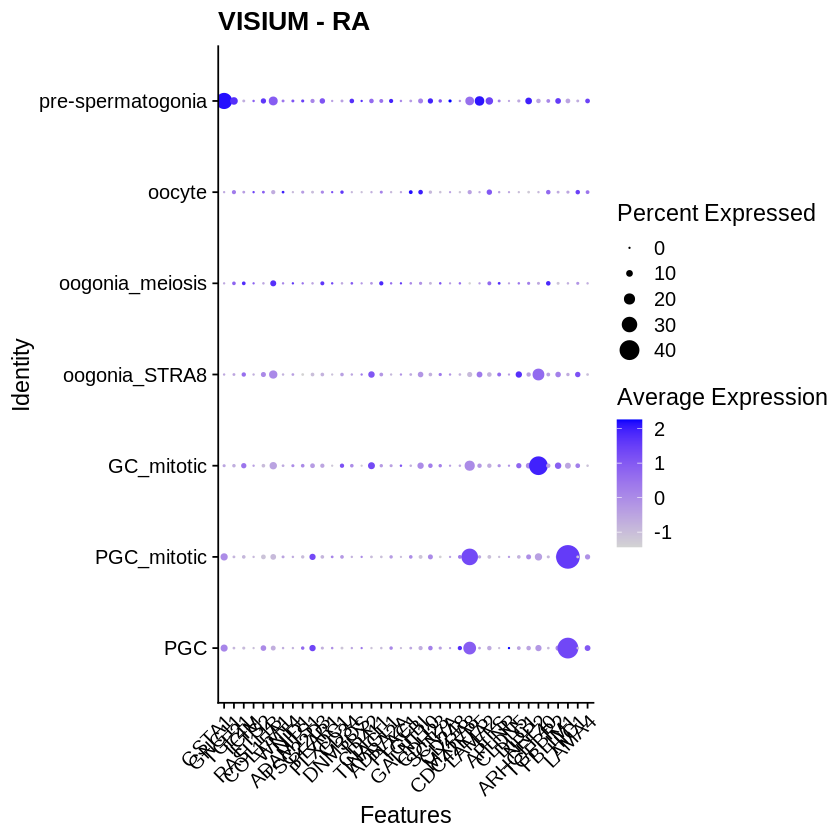

In [22]:
DotPlot(anndataO, features = c('NLRP5',  'FOLR1',  'ZAR1', 'ADAP1',
'CSF1R', 'GPM6B', 'MCTP1', 'PLEK2', 'TUBB8', 'CTRB2', 'LINC01467', 'OOSP2', 
'TUBA4A', 'KPNA7', 'LINC01511', 'UNC13C', 'CTRB1', 'EFCAB10', 'NLRP9', 'LAD1', 'BAALC',
'LDHAL6A', 'DEGS2', 'SLC38A8', 'TP63', 'MYOCOS', 'CHRNA3', 'LINC02763', 'ASGR2', 'PATL2ZP2',
'IGHE', 'SLC3A1', 'ARG2')) + RotatedAxis() +  theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('VISIUM - oocyte cluster') 


DotPlot(anndataO, features = c('VCX2',  'SYNGR4', 'MEIOC', 'TEX14', 'RAD51AP2',  
'SHCBP1L', 'CNTD1', 'MAJIN', 'HAUS8', 'DYDC1', 'ESCO2', 'GLCCI1', 'PSMA8', 'CTCFL',
'DMRTB1', 'ZPBP2', 'VCX3A', 'RBM46', 'FKBP6', 'ARID3B', 'TEX12', 'MED8', 'UCHL3',
'CDC45', 'TEX19', 'TEX15', 'RNF212', 'HFM1', 'CCNE2', 'PI4K2B', 'FR')) + RotatedAxis() +  theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('VISIUM - meiosis') 



DotPlot(anndataO, features = c('FRZBENG', 'GSTA1', 'GNG11',  'TCF21', 'TCIM',
'ETS2', 'RASL11B', 'COL15A1', 'WNT4', 'NID1', 'ADAMTS1', 'TSC22D3', 'PEAR1',
'PLXDC1', 'CD34', 'DNM3OS', 'TBX2', 'CDH11',
'TINAGL1', 'ADRA2A', 'PLAC1', 'TGFBI', 'GALNT10', 'CDH23',
'SCN7A', 'CD248', 'MXRA8', 'CDC42EP5', 'LAMA2', 'EFS', 'APLNR', 'CLDN5', 'DLC1', 
                            'NRP2', 'ARHGEF40', 'TGFBR2', 'FBLIM1', 'HIC1', 'LAMA4')) + RotatedAxis() +  theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('VISIUM - RA') 

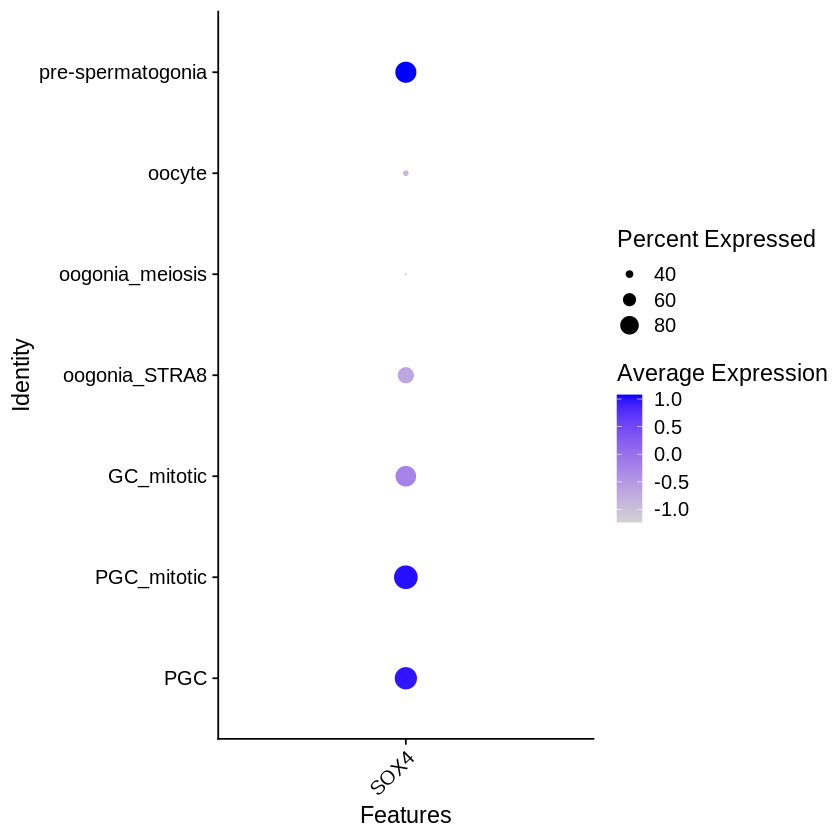

In [23]:

DotPlot(anndataO, features = c('SOX4') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))



Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: HERPUD”
Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: HERPUD”


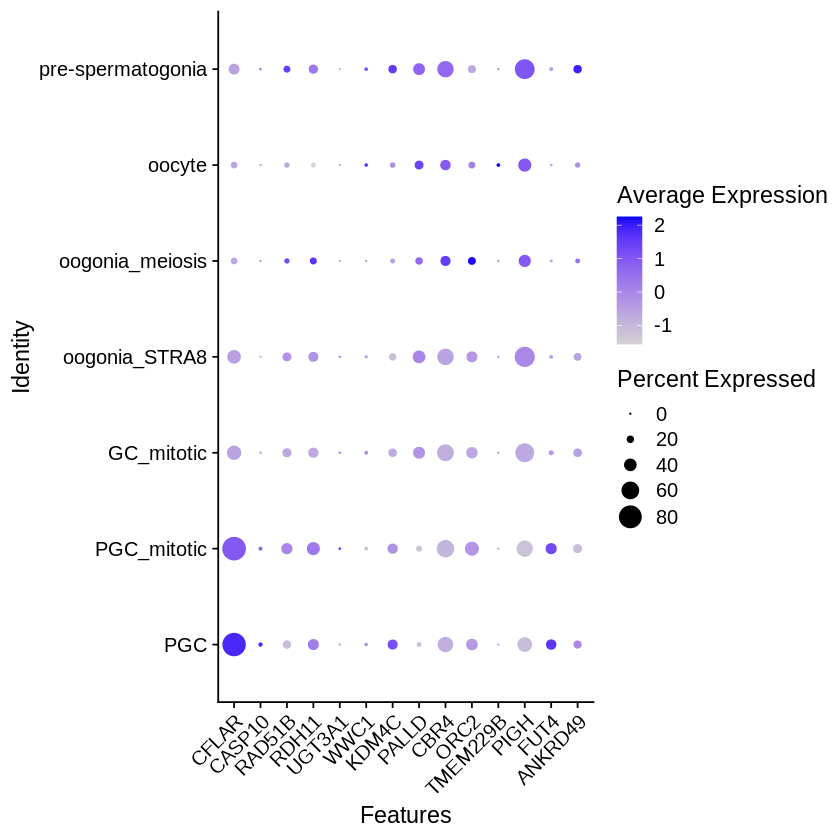

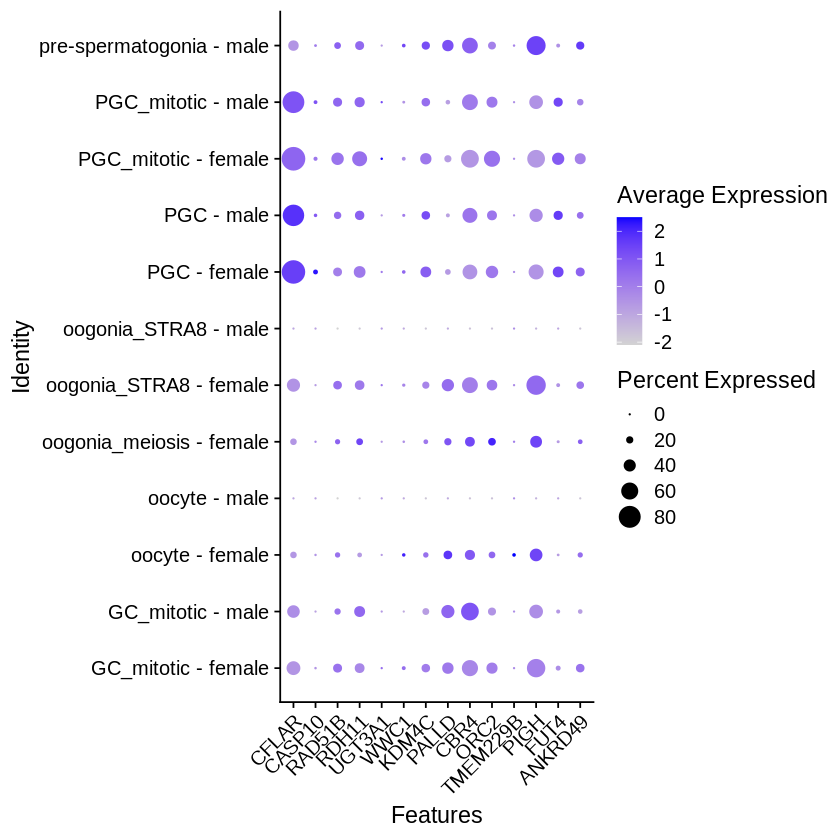

In [24]:
DotPlot(anndataO, features = c('CFLAR', 'CASP10', 'RAD51B', 'RDH11', 'UGT3A1', 'WWC1', 'KDM4C', 'HERPUD', 'PALLD', 'CBR4', 'ORC2', 'TMEM229B', 'PIGH', 'FUT4', 'ANKRD49') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))


DotPlot(anndataO, features = c('CFLAR', 'CASP10', 'RAD51B', 'RDH11', 'UGT3A1', 'WWC1', 'KDM4C', 'HERPUD', 'PALLD', 'CBR4', 'ORC2', 'TMEM229B', 'PIGH', 'FUT4', 'ANKRD49'), group.by='sex_annot' ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))


Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: SSTR1”


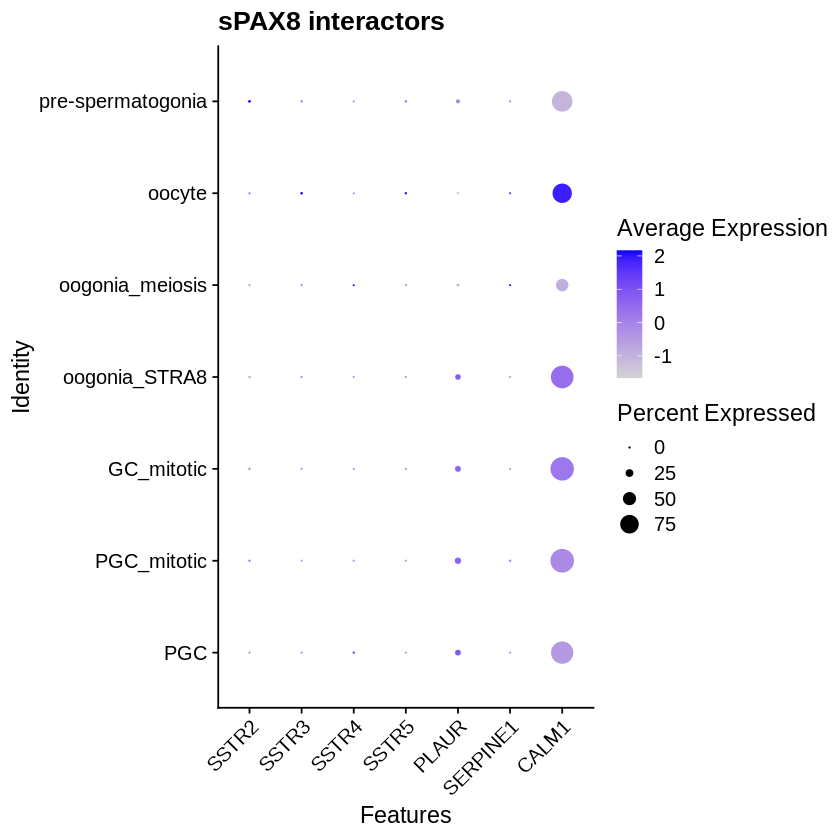

In [25]:
DotPlot(anndataO, features = c('SSTR1', 'SSTR2',  'SSTR3', 'SSTR4', 'SSTR5', 'PLAUR', 'SERPINE1', 'CALM1') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('sPAX8 interactors')

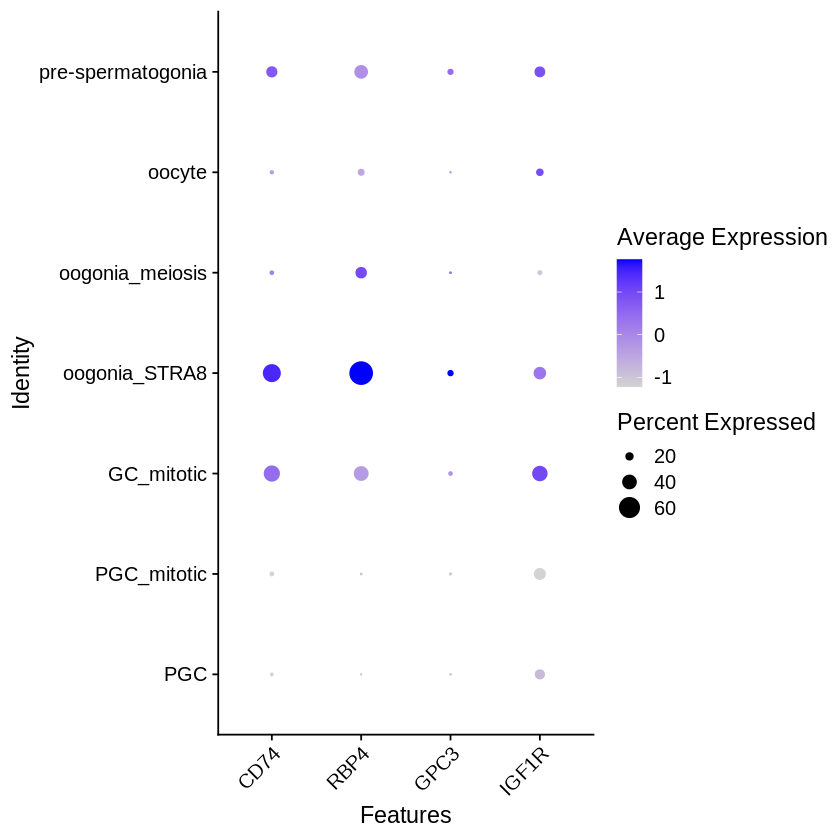

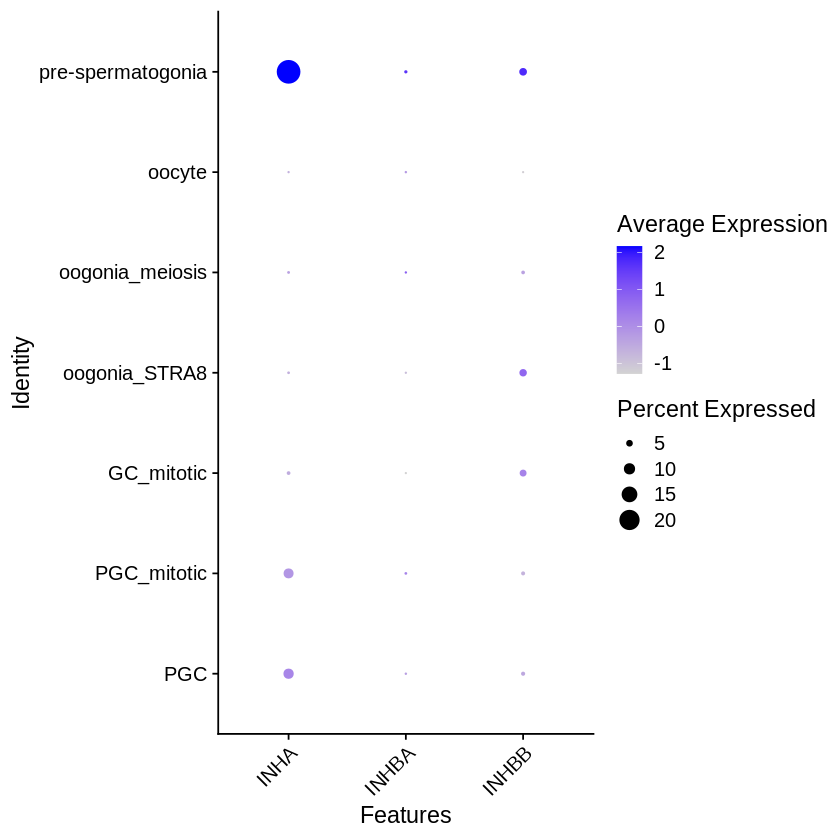

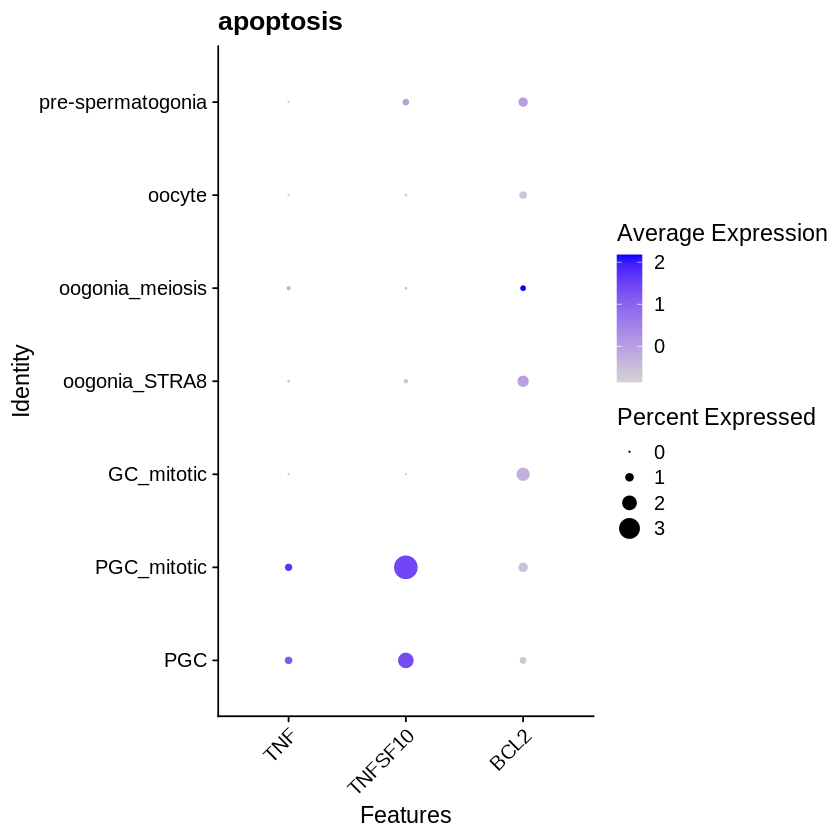

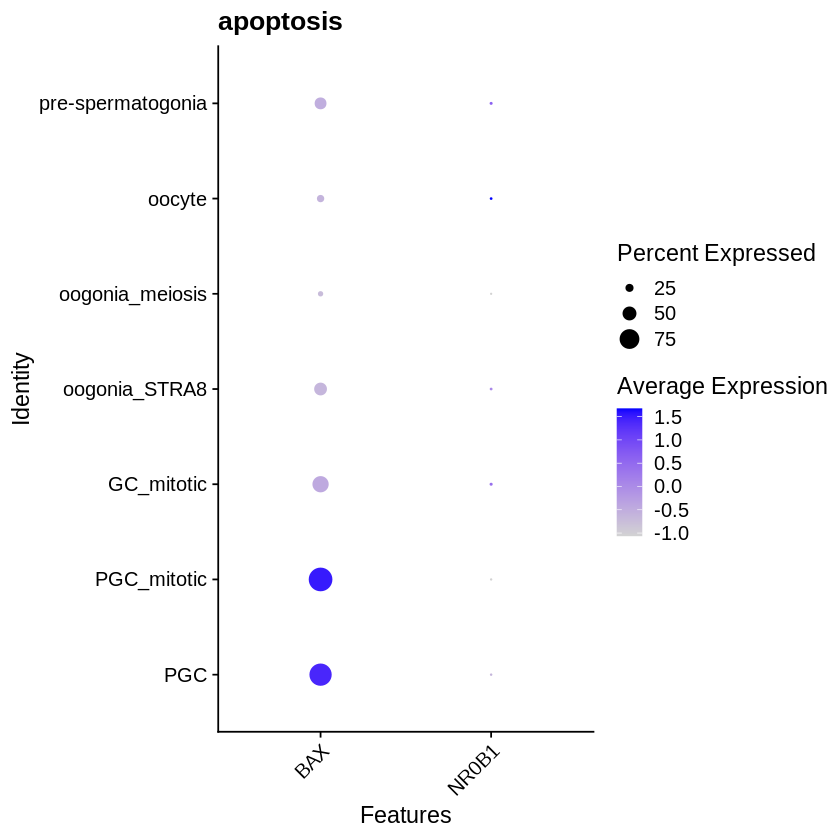

In [26]:
DotPlot(anndataO, features = c('CD74', 'RBP4', 'GPC3', 'IGF1R') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))
DotPlot(anndataO, features = c('INHA', 'INHBA', 'INHBB') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))
DotPlot(anndataO, features = c('TNF',  'TNFSF10', 'BCL2') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('apoptosis')
DotPlot(anndataO, features = c('BAX', 'NR0B1') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('apoptosis')

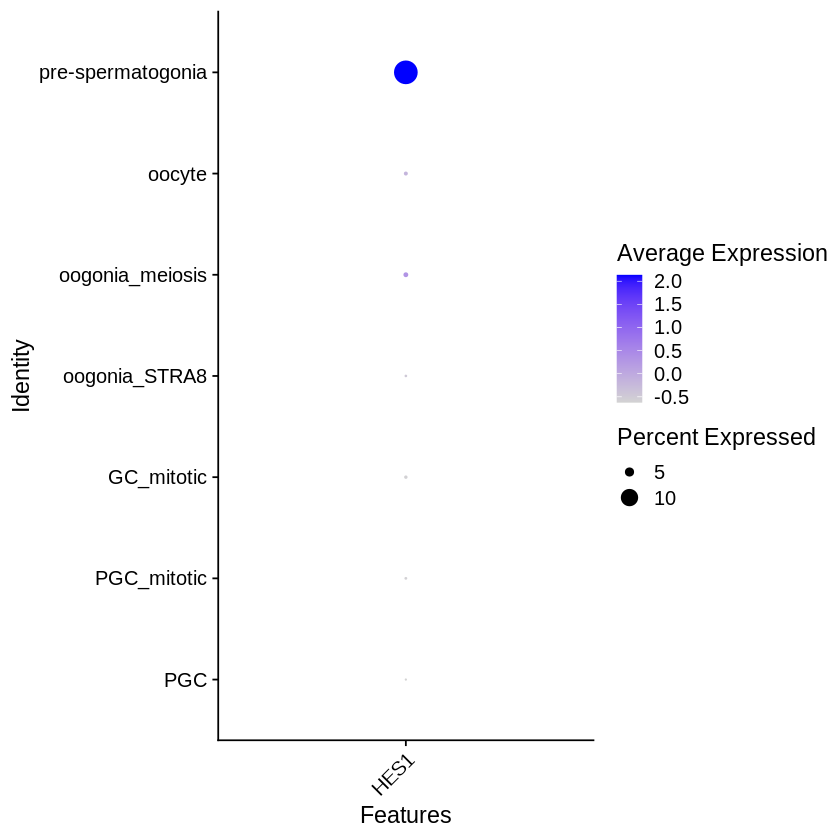

In [27]:
DotPlot(anndataO, features = c('HES1')) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) 

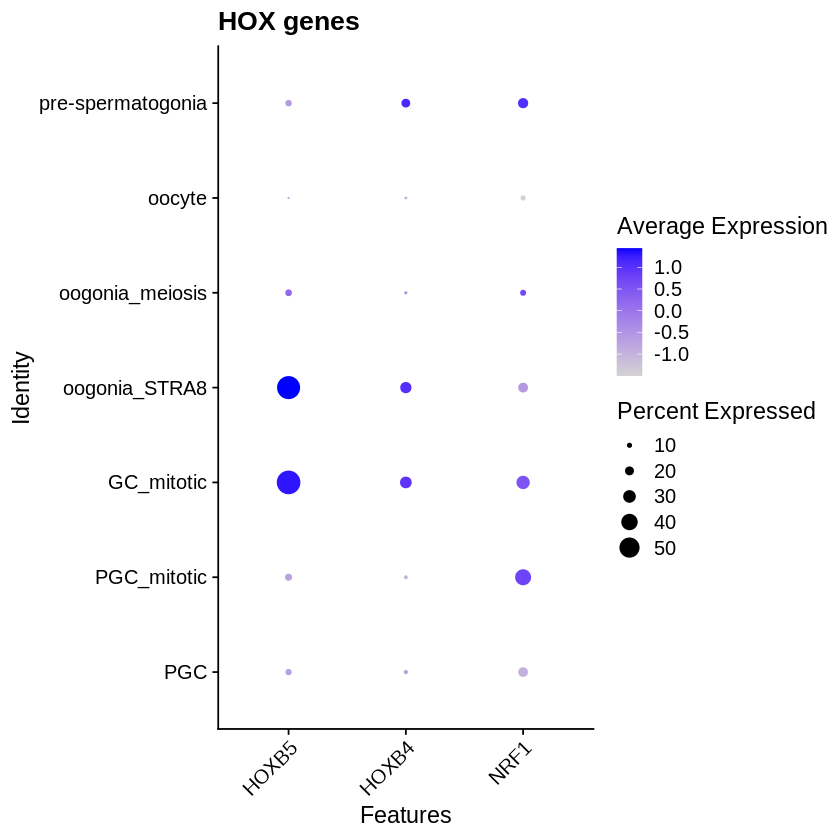

In [28]:
DotPlot(anndataO, features = c('HOXB5', 'HOXB4', 'NRF1')) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced")) + ggtitle('HOX genes')

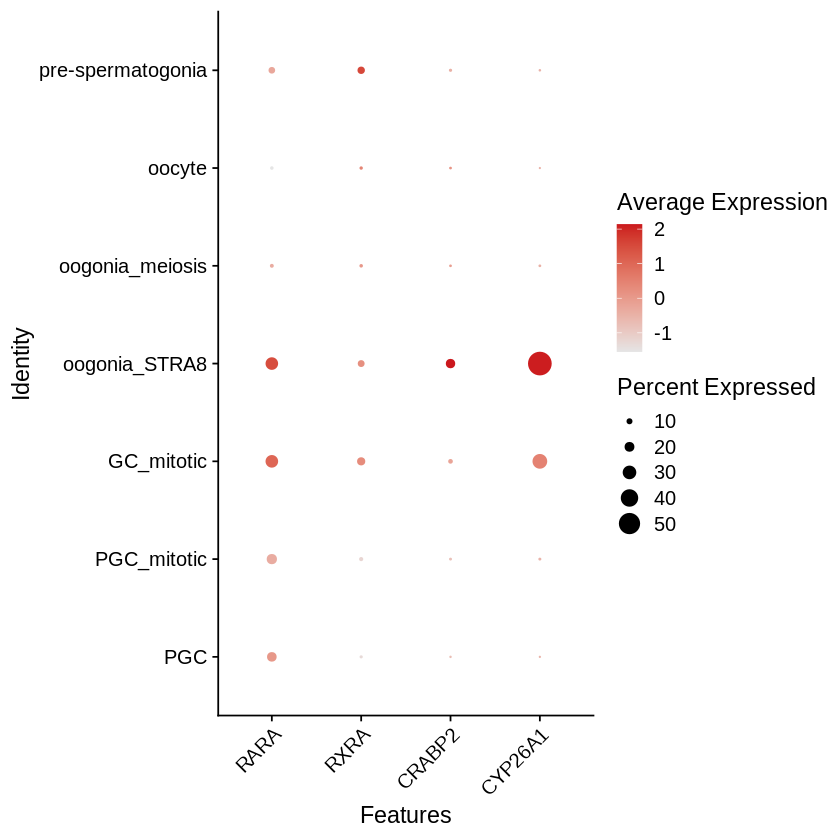

In [29]:
DotPlot(anndataO, features = c('RARA',  'RXRA', 'CRABP2', 'CYP26A1'), cols = col_dot) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-germcells/0_Fint_dotplot_RAresponse.pdf'), dpi = 75, height = 4, width = 5.5)


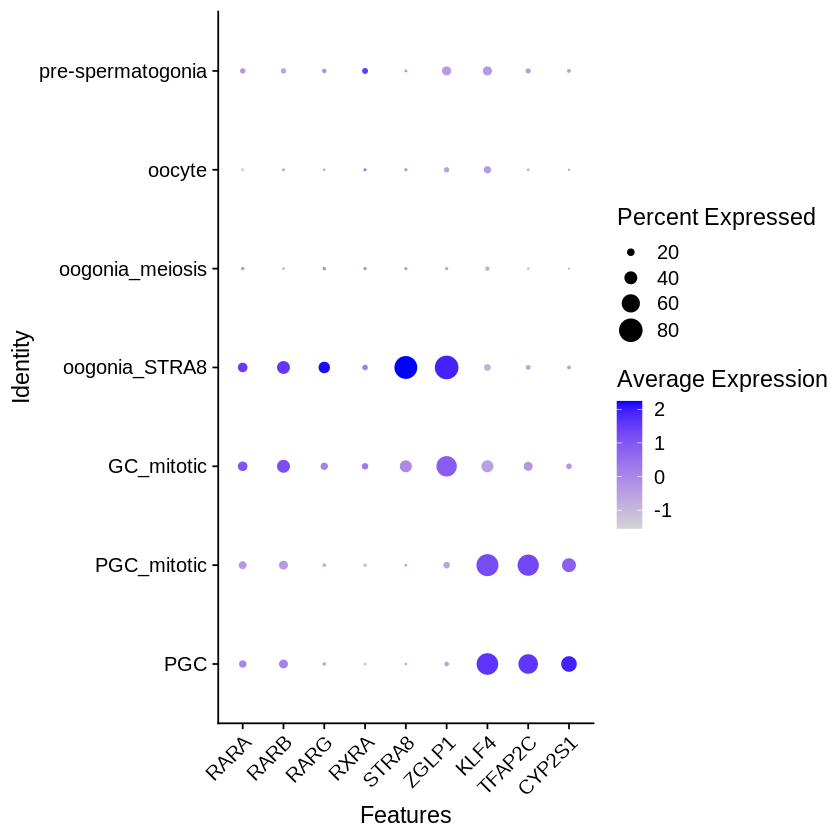

In [30]:
DotPlot(anndataO, features = c('RARA', 'RARB', 'RARG', 'RXRA',  'STRA8', 'ZGLP1', "KLF4","TFAP2C", 'CYP2S1') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))

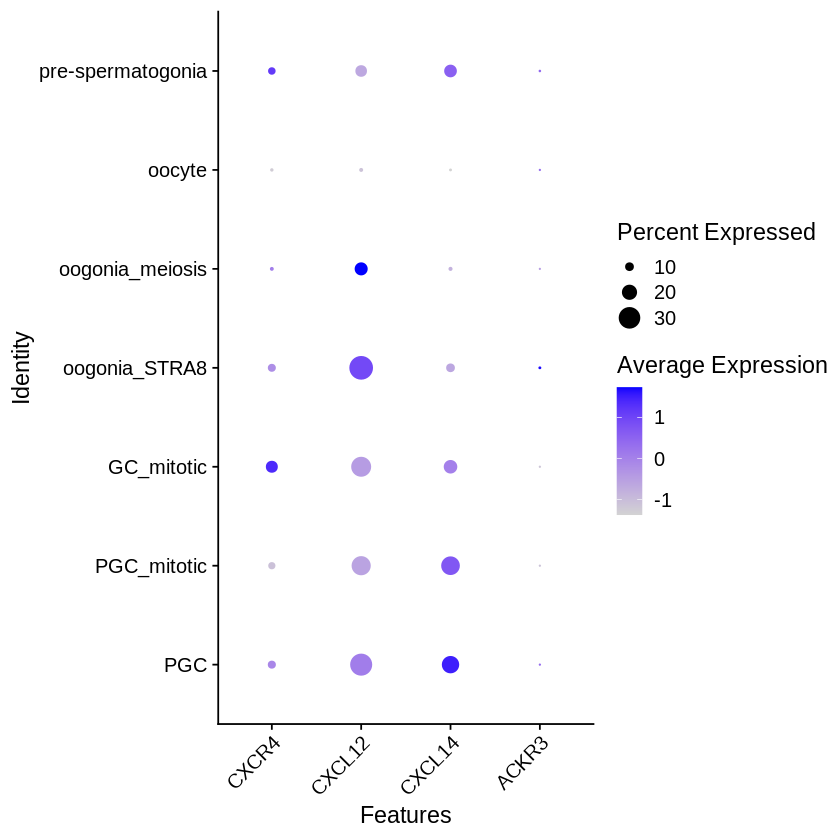

In [31]:
DotPlot(anndataO, features = c('CXCR4', 'CXCL12', 'CXCL14', 'ACKR3') ) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))

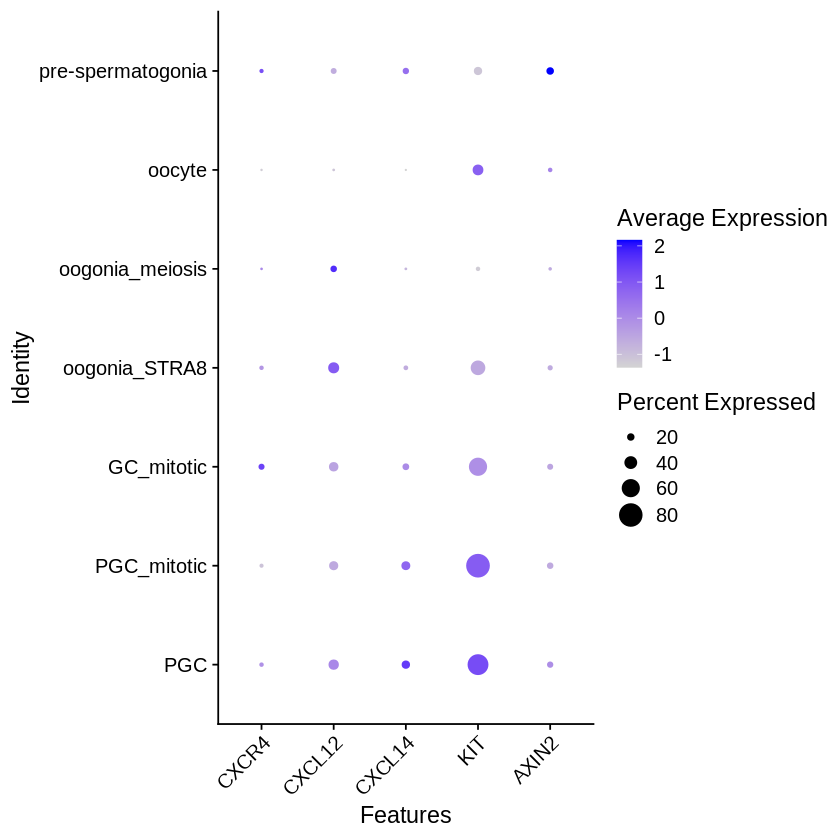

In [32]:
DotPlot(anndataO, features = c('CXCR4', 'CXCL12', 'CXCL14', 'KIT', 'AXIN2')) + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



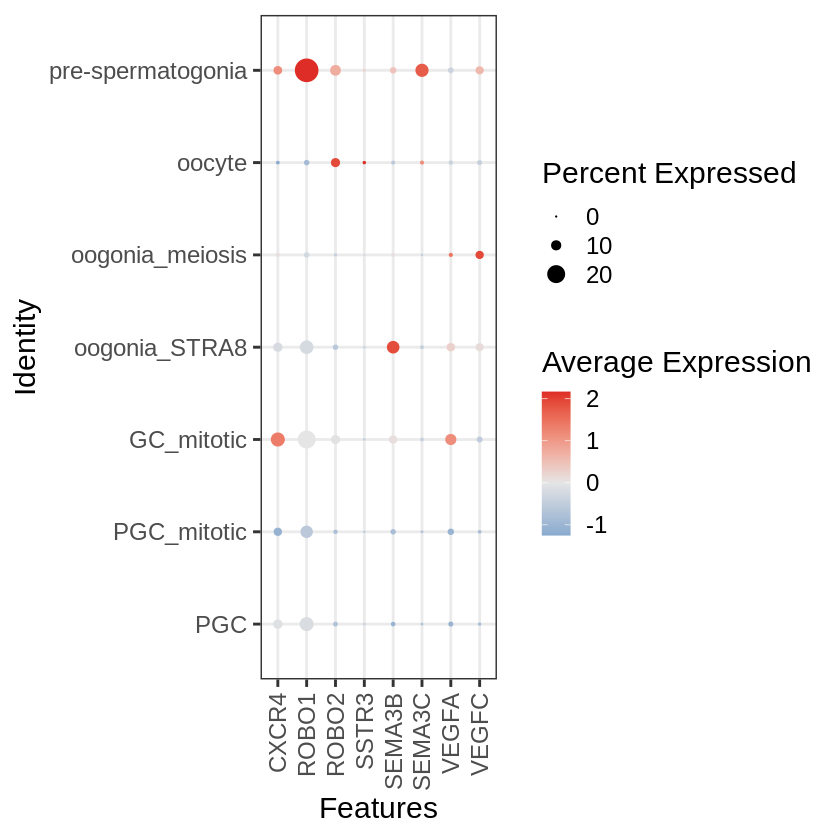

In [35]:
anndataO = subset(anndataO, cells = Cells(anndataO)[ ! anndataO$annotated_clusters %in% c('doublet', 'cycling') ] )
# DotPlot(anndataO, features = c('CXCR4',  'ROBO1', 'ROBO2', 'SSTR3', 'SEMA3B','SEMA3C', 'VEGFA', 'VEGFC', 'TMEM219'))  +  
DotPlot(anndataO, features = c('CXCR4',  'ROBO1', 'ROBO2', 'SSTR3', 'SEMA3B','SEMA3C', 'VEGFA', 'VEGFC'))  +  
    scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                          high = brewer.pal(n = 5, name = 'Reds')[4], 
                          mid = 'grey90') + theme_bw(18) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 
ggsave(filename = paste0('figures-germcells/0_F1_dotplot_sPAX8_receptors.pdf'), dpi = 75, height = 3, width = 7)

## Unbiased markers

### High resolution populations

[1] 23556    10

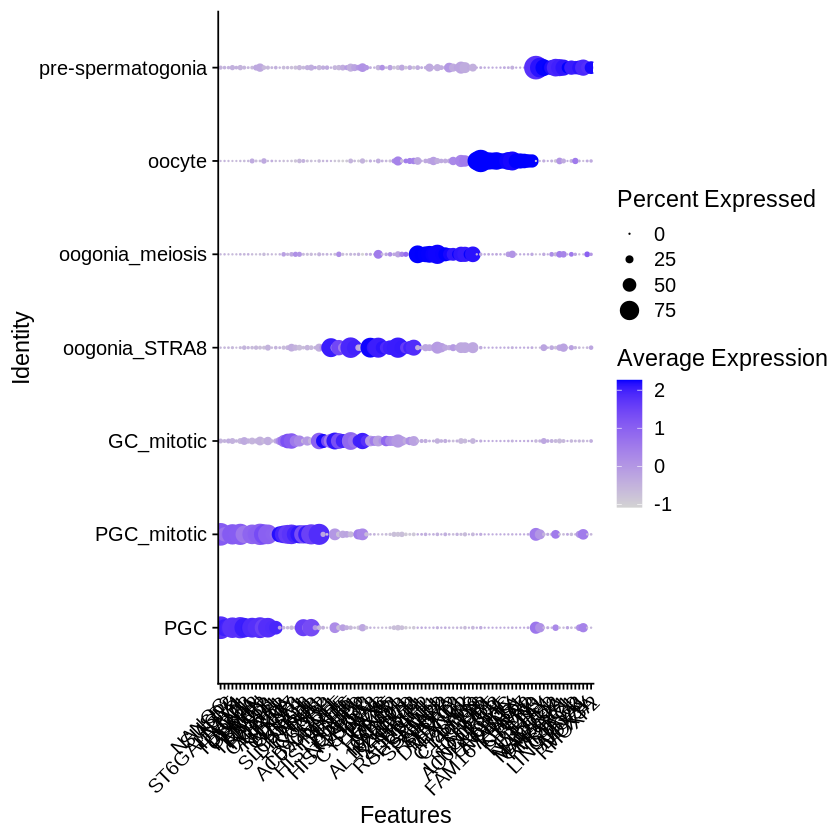

In [34]:
aAll = downsample_data(anndataO, var = 'annotated_clusters', N = 200)
df_tfIDF = quickMarkers(toc = aAll@assays$RNA@counts, clusters = aAll$annotated_clusters, N = 100000)
dim(df_tfIDF)
write.csv(df_tfIDF, file = 'figures-germcells/0_FS1_table_TFIDF_annotated.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_TFIDF_annotated.pdf'), dpi = 75, height = 5, width = 45)

## Sexually dimorphic markers in bipotent cells

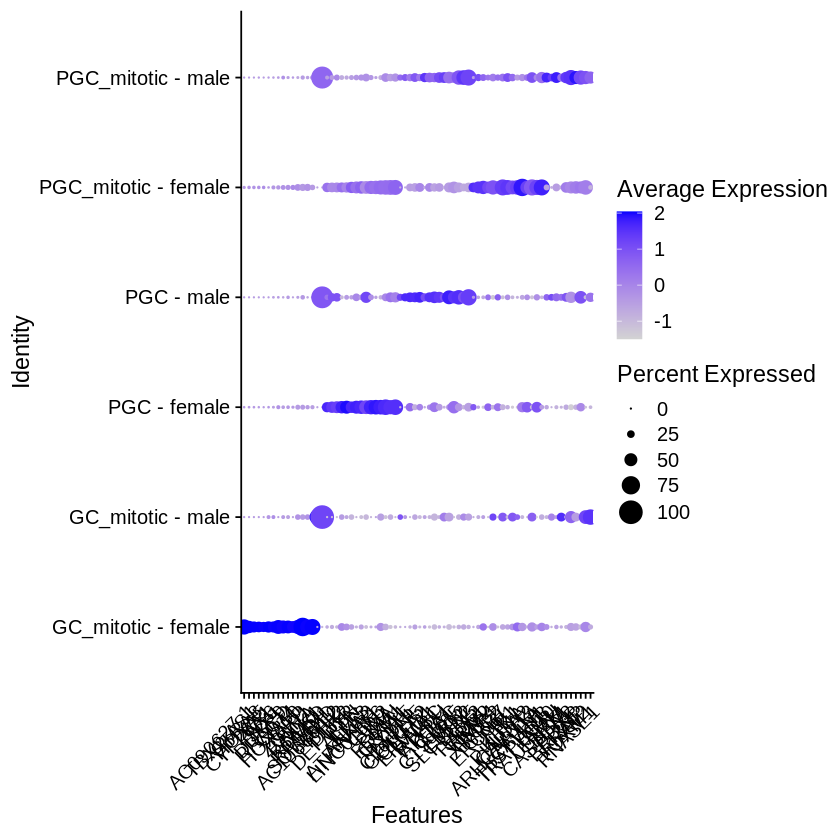

In [35]:
Bp = subset(anndataO, cells = colnames(anndataO)[ Idents(anndataO) %in% c('PGC_XIST', 'PGC' ,'PGC_mitotic','GC_mitotic') ] )
Bp = downsample_data(Bp, var = 'annotated_clusters', N = 300)

df_tfIDF = quickMarkers(toc = Bp@assays$RNA@counts, clusters = Bp$sex_annot, N = 20)
df_tfIDF = df_tfIDF[ order(df_tfIDF$geneFrequencySecondBest, decreasing = F), ]
write.csv(df_tfIDF, file = 'figures-germcells/0_FS2_table_sexTFIDFinBipotent.csv', quote = F, row.names = F)

DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(Bp, features = unique(DEGs_tfIDF), group.by = 'sex_annot') + RotatedAxis()
ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_sexTFIDFinBipotent.pdf'), dpi = 75, height = 5, width = 45)

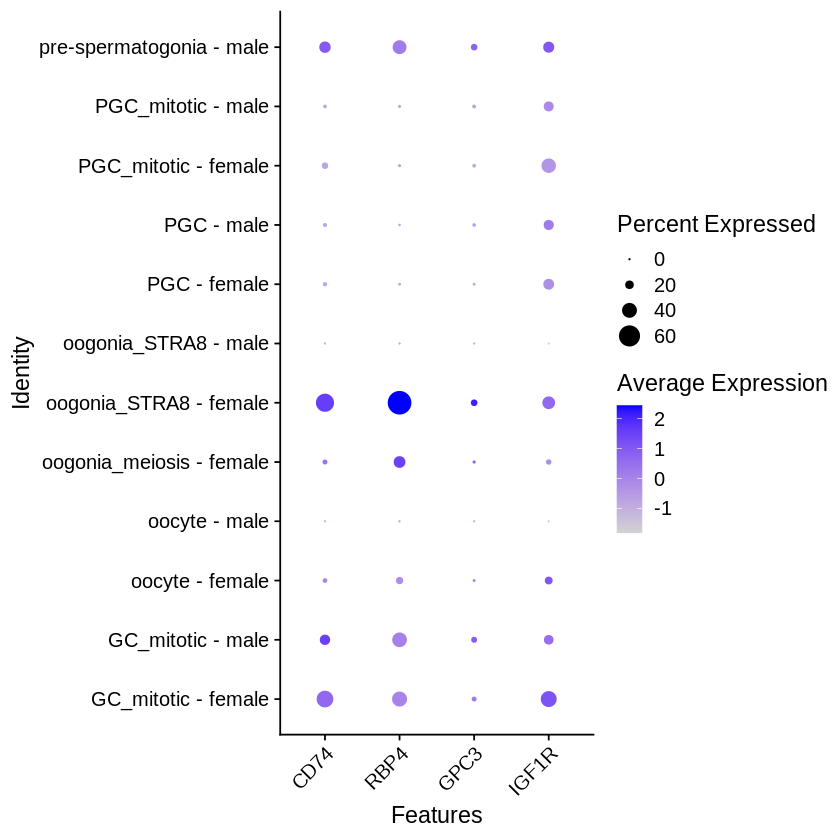

In [36]:
DotPlot(anndataO, features = c('CD74', 'RBP4', 'GPC3', 'IGF1R'), group.by='sex_annot') + RotatedAxis() + 
    theme(strip.text.x = element_text(angle=90, hjust=0),
          strip.background = element_rect(fill="#e8eced"))


PGC - female   PGC - male 
          30           30 

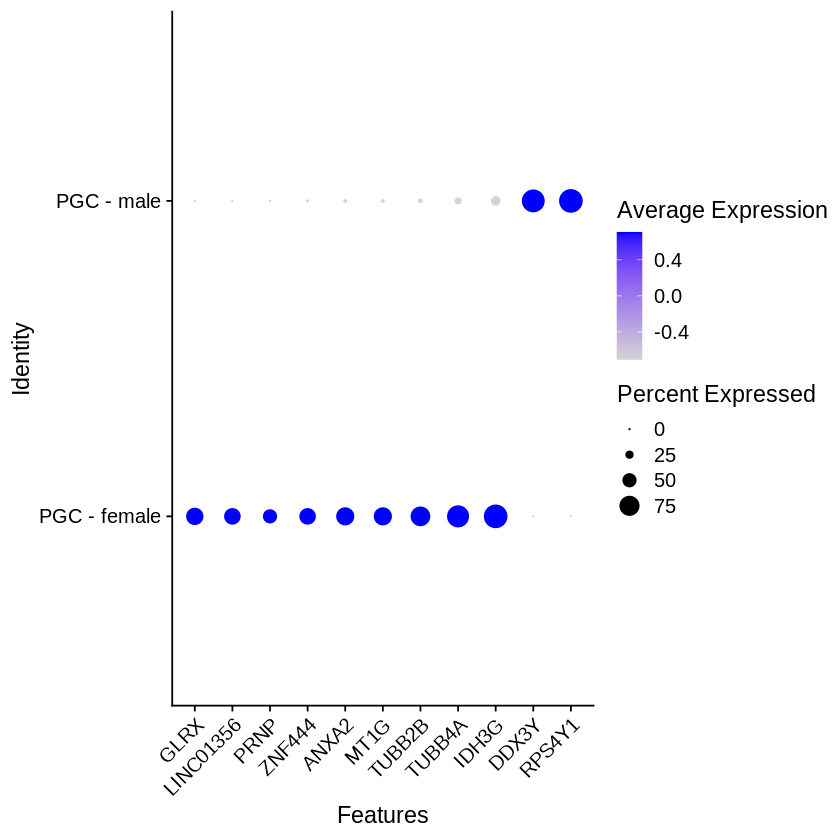

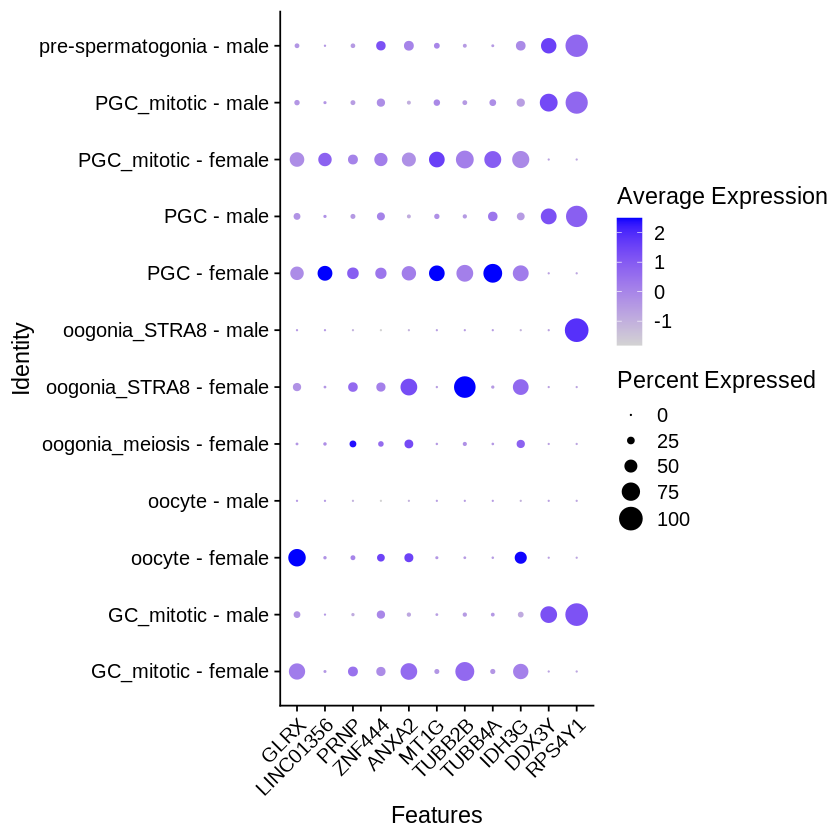

In [37]:
BpY = subset(anndataO, cells = colnames(anndataO)[ Idents(anndataO) %in% c('PGC') ] )
BpY = downsample_data(BpY, var = 'sex_annot', N = 30)

table(BpY$sex_annot)
df_tfIDF = quickMarkers(toc = BpY@assays$RNA@counts, clusters = BpY$sex_annot, N = 20)
df_tfIDF = df_tfIDF[ order(df_tfIDF$geneFrequencySecondBest, decreasing = F), ]
write.csv(df_tfIDF, file = 'figures-germcells/0_FS2_table_sexTFIDFinPGC.csv', quote = F, row.names = F)

DEGs_tfIDF = subset(df_tfIDF, qval <= 0.1) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 25L)$gene) %>%
  unlist(.)
DotPlot(BpY, features = unique(DEGs_tfIDF), group.by = 'sex_annot') + RotatedAxis()
ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_sexTFIDFinPGC.pdf'), dpi = 75, height = 5, width = 45)


DEGs_tfIDF = subset(df_tfIDF, qval <= 0.1) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 25L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'sex_annot') + RotatedAxis()
ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_sexTFIDFinPGC.pdf'), dpi = 75, height = 5, width = 45)


 GC_mitotic - female    GC_mitotic - male         PGC - female 
                  30                    1                   30 
          PGC - male PGC_mitotic - female   PGC_mitotic - male 
                  30                   30                    5 

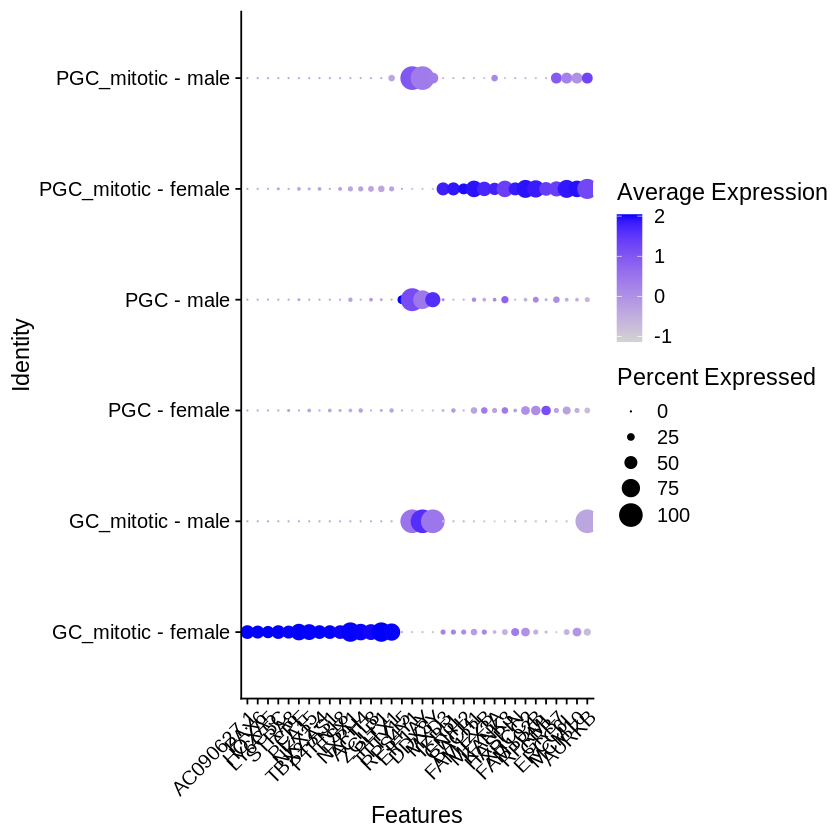

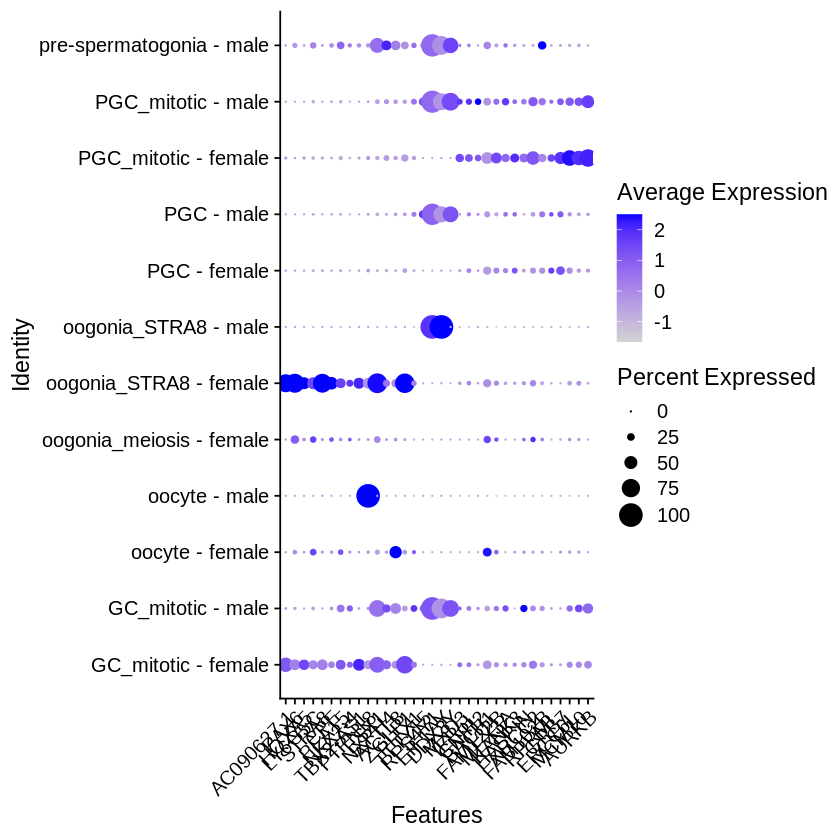

In [38]:
BpY = subset(anndataO, cells = colnames(anndataO)[ Idents(anndataO) %in% c('PGC_XIST', 'PGC' ,'PGC_mitotic','GC_mitotic') ] )
BpY = subset(BpY, cells = colnames(BpY)[ BpY$stage < 11 ] )

BpY = downsample_data(BpY, var = 'sex_annot', N = 30)

table(BpY$sex_annot)
df_tfIDF = quickMarkers(toc = BpY@assays$RNA@counts, clusters = BpY$sex_annot, N = 20)
df_tfIDF = df_tfIDF[ order(df_tfIDF$geneFrequencySecondBest, decreasing = F), ]
write.csv(df_tfIDF, file = 'figures-germcells/0_FS2_table_sexTFIDFinYoungBipotent.csv', quote = F, row.names = F)

DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(BpY, features = unique(DEGs_tfIDF), group.by = 'sex_annot') + RotatedAxis()
ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_sexTFIDFinYoungBipotent.pdf'), dpi = 75, height = 5, width = 45)


DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'sex_annot') + RotatedAxis()
ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_sexTFIDFinYoungBipotent2.pdf'), dpi = 75, height = 5, width = 45)

## Female specific markers

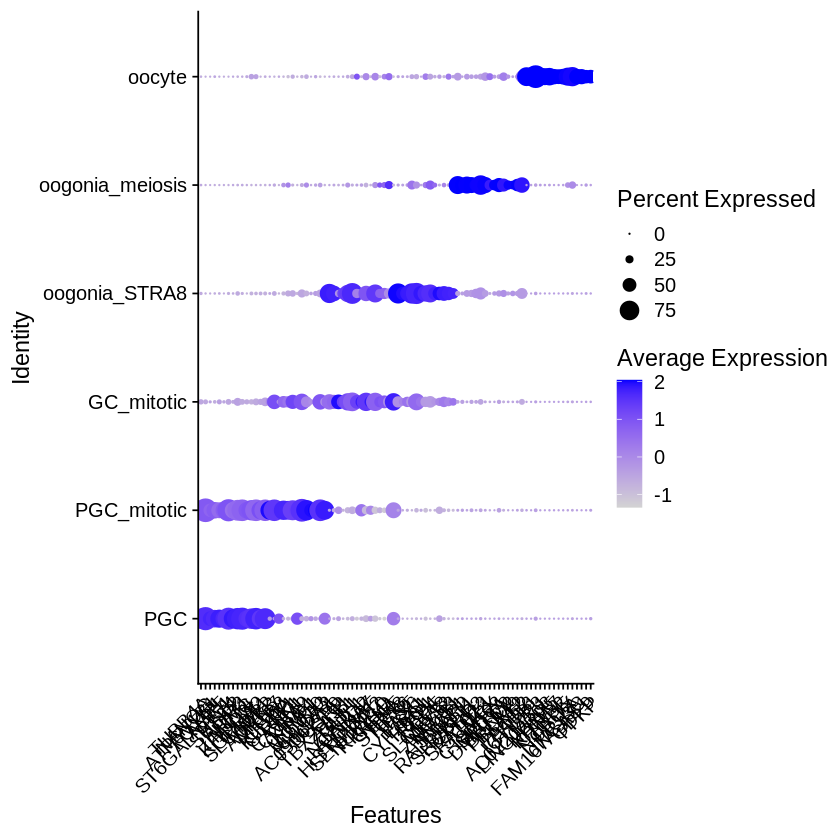

In [39]:
aFemale = subset(anndataO, cells = colnames(anndataO)[ ! anndataO$annotated_clusters %in% c('gonocyte') & anndataO$sex == 'female'])
femaleDown = downsample_data(aFemale, var = 'annotated_clusters', N = 150)

df_tfIDF = quickMarkers(toc = femaleDown@assays$RNA@counts, clusters = femaleDown$annotated_clusters, N = 20)
df_tfIDF = df_tfIDF[ order(df_tfIDF$geneFrequencySecondBest, decreasing = F), ]
write.csv(df_tfIDF, file = 'figures-germcells/0_FS2_table_TFIDF_female.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(femaleDown$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(aFemale, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_TFIDF_female.pdf'), dpi = 75, height = 5, width = 45)

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: ESRRB”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



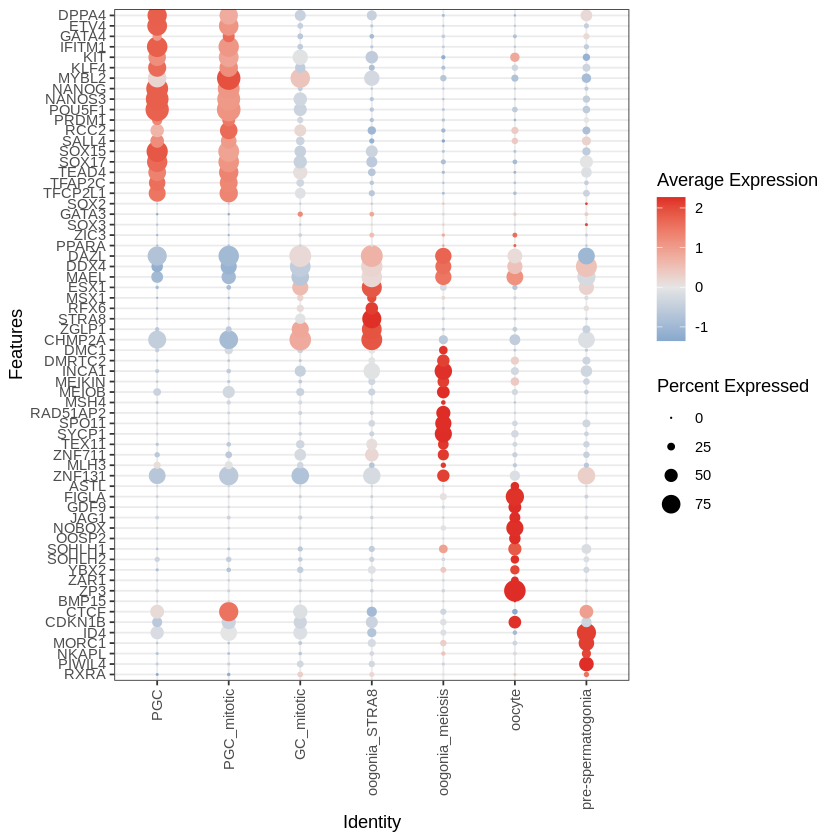

In [40]:
# Plot known oogenesis markers
markers_crosspecie = c('DPPA4', 'ETV4', 'GATA4', 'IFITM1', 'KIT', 'KLF4',  'MYBL2', 'NANOG', 'NANOS3', 'POU5F1', 'PRDM1', 'RCC2', 'SALL4', 'SOX15', 'SOX17', 'TEAD4', 'TFAP2C', 'TFCP2L1', 'ESRRB', 'SOX2', 'GATA3',  'SOX3', 'ZIC3',  'PPARA', 
                       'DAZL', 'DDX4', 'MAEL', 'ESX1', 'MSX1', 'RFX6', 'STRA8', 'ZGLP1', 
                       'CHMP2A', 'DMC1', 'DMRTC2', 'INCA1', 'MEIKIN', 'MEIOB', 'MSH4', 'RAD51AP2', 'SPO11', 'SYCP1',  'TEX11', 'ZNF711', 'MLH3', 'ZNF131', 'ASTL', 'FIGLA', 'GDF9', 'JAG1', 'NOBOX', 'OOSP2', 'SOHLH1', 'SOHLH2', 'YBX2', 'ZAR1', 'ZP3','BMP15',
                        'CDKN1B', 'CTCF', 'CTCFL', 'DNMT3L',  'ID4', 'MEI1', 'MORC1', 'NANOS2', 'NKAPL', 'PIWIL4', 'RARB', 'RXRA')



DotPlot(anndataO, features = rev(markers_crosspecie)) + RotatedAxis() +  theme_bw() + 
        theme(axis.text.x = element_text(angle=90, hjust=1, vjust = 0.5),
          strip.background = element_rect(fill="#e8eced")) + coord_flip() +
         scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                              high = brewer.pal(n = 5, name = 'Reds')[4], 
                              mid = 'grey90')
ggsave(filename = paste0('figures-germcells/0_F1_dotplot_crosspecie_markers.pdf'), dpi = 75, height = 10.5, width = 4)

[1] "SOX13\",\"STAT3\",\"TEAD2\",\"GTF2I\",\"NR2F6\",\"SOX4\",\"HOXA2\",\"HOXA3\",\"HOXA5\",\"PBX1\",\"ZIC1\",\"PAX6\",\"RARB\",\"RARG\",\"SIX1\",\"KLF10\",\"SOX30\",\"ARID4B\",\"DMRTB1\",\"HESX1\",\"HINFP\",\"HOXD8\",\"HSF2\",\"ID2\",\"MBD1\",\"MEF2A\",\"ZHX1\",\"TP63\",\"TSC22D1\",\"ZHX3\",\"EGR4\",\"ETV6\",\"KLF7\",\"MAFG\",\"NFIL3\",\"TWIST1\",\"ZNF652"

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



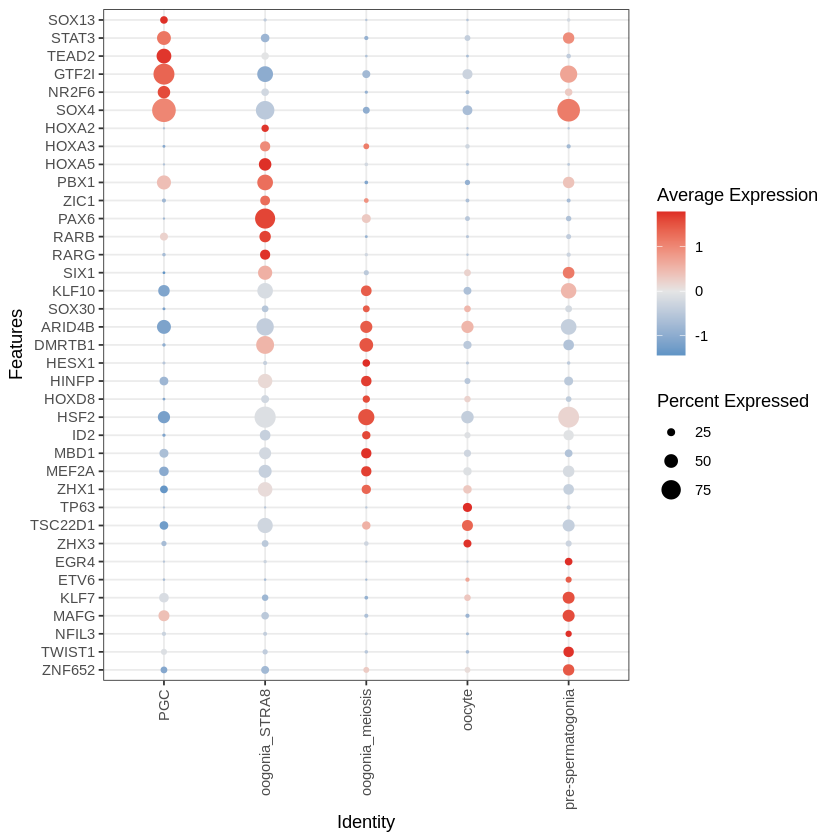

In [42]:
# Plot new TFs
TFs = read.csv('figures-germcells/0_FS1_table_TFs_intersection_SELECTED.csv', stringsAsFactors = F)
newTFs = subset(TFs, ! (cluster == 'pre-spermatogonia' & N_agreement == 2 ) 
                & ! TF %in% markers_crosspecie )$TF %>% unique(.)
paste(newTFs, collapse = '\",\"')
DotPlot(subset(anndataO, cells = Cells(anndataO)[ ! Idents(anndataO) %in% c('PGC_mitotic', 'GC_mitotic')  ] ), features = rev(newTFs)) + RotatedAxis() +  theme_bw() + 
        theme(axis.text.x = element_text(angle=90, hjust=1, vjust = 0.5),
          strip.background = element_rect(fill="#e8eced")) + coord_flip() +
         scale_color_gradient2(low = brewer.pal(n = 5, name = 'Blues')[4], 
                              high = brewer.pal(n = 5, name = 'Reds')[4], 
                              mid = 'grey90')
ggsave(filename = paste0('figures-germcells/0_F1_dotplot_crosspecie_newTFs.pdf'), dpi = 75, height = 6, width = 4)

## Male specific markers

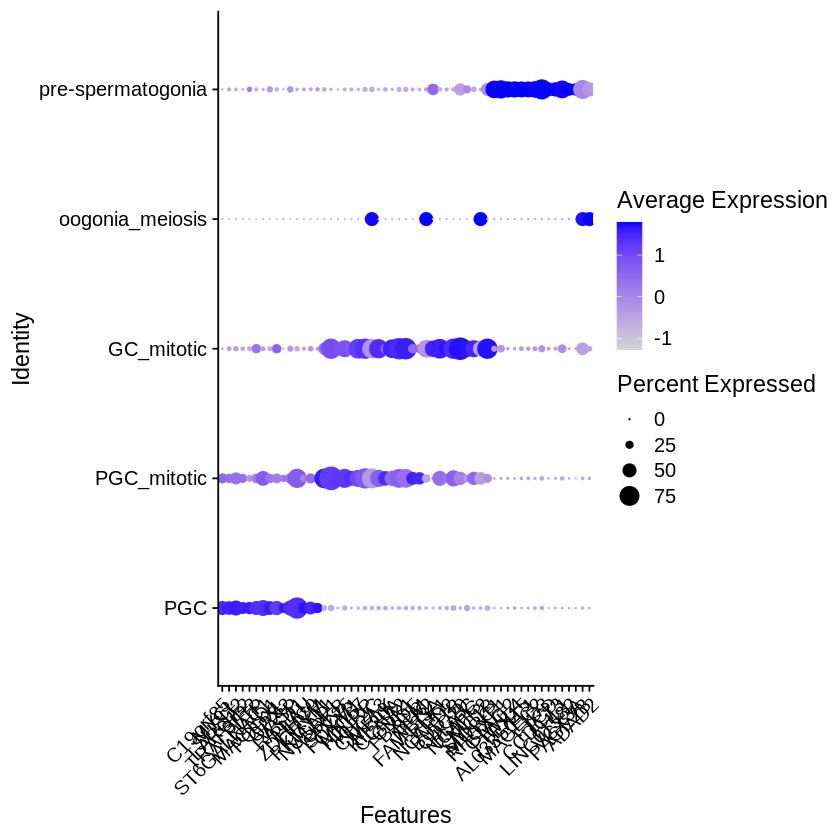

In [52]:
aMale = subset(anndataO, cells = colnames(anndataO)[ ! anndataO$annotated_clusters %in% c('oogonia_STRA8','oogonia_meiotic','oocyte') & anndataO$sex == 'male'])
maleDown = downsample_data(aMale, var = 'annotated_clusters', N = 100)

df_tfIDF = quickMarkers(toc = maleDown@assays$RNA@counts, clusters = maleDown$annotated_clusters, N = 20)
df_tfIDF = df_tfIDF[ order(df_tfIDF$geneFrequencySecondBest, decreasing = F), ]
write.csv(df_tfIDF, file = 'figures-germcells/0_FS2_table_TFIDF_male.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(maleDown$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(maleDown, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_TFIDF_male.pdf'), dpi = 75, height = 5, width = 45)

In [54]:
# # plot markers of key pathways
# pathway_markers = readRDS(file = '~/farm/gsea/genesets/pathway_markers.rds')
# df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 1000)

# for (pa in names(pathway_markers) ){
#         genes = intersect(pathway_markers[[pa]], df_tfIDF$gene)
#         if(length(genes) <= 1)
#             next()
#         DotPlot(anndataO, features = genes) + RotatedAxis() + ggtitle(pa)
#         ggsave(filename = paste0('figures-germcells/dotplot_annotated_', pa,'.pdf'), dpi = 75, height = 5, width = 10)
# }

# DEGs

### High resolution populations

Calculating cluster PGC

Calculating cluster PGC_mitotic

Calculating cluster GC_mitotic

Calculating cluster oogonia_STRA8

Calculating cluster oogonia_meiosis

Calculating cluster oocyte

Calculating cluster pre-spermatogonia



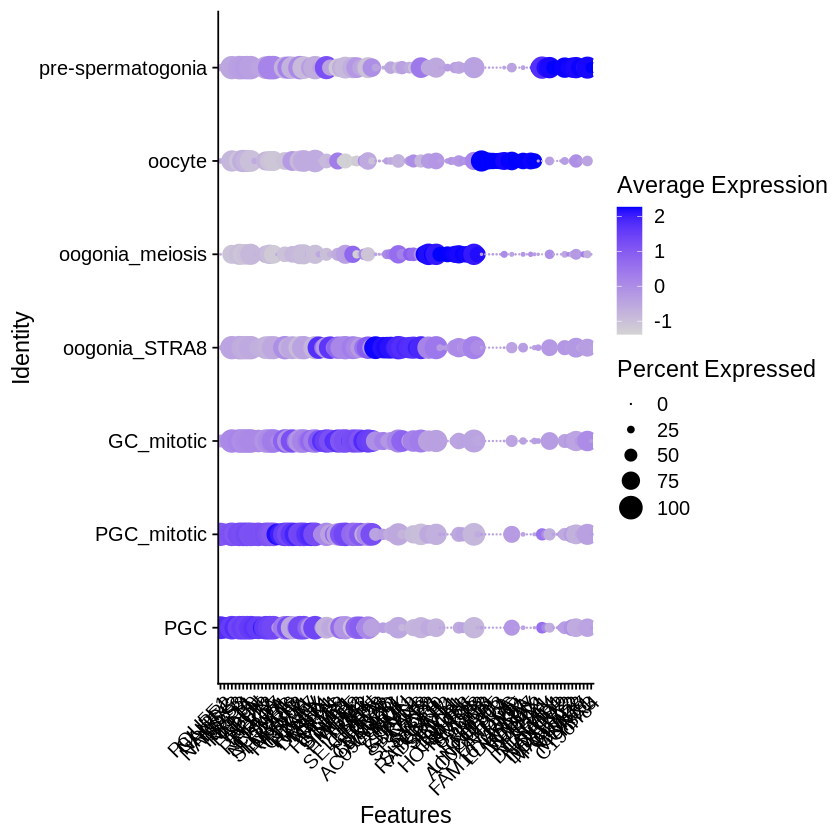

In [56]:
suppressWarnings(dfDEGs <- FindAllMarkers(aAll, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0.05, return.thresh = 1))
if (is.null(dfDEGs$avg_log2FC) )
    dfDEGs$avg_log2FC = dfDEGs$avg_logFC
write.csv(dfDEGs, file = 'figures-germcells/0_FS1_table_DEGs.csv', quote = F, row.names = F)


# Plot top DEGs
DEGs = subset(dfDEGs, avg_logFC > 0.5) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs)) + RotatedAxis()
ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_DEGs.pdf'), dpi = 75, height = 7, width = 45)

### Female specific DEGs

In [55]:
# suppressWarnings(dfDEGs <- FindAllMarkers(femaleDown, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1))
# write.csv(dfDEGs, file = 'figures-germcells/0_FS1_table_DEGs_female.csv', quote = F, row.names = F)

# # Plot top DEGs
# DEGs = subset(dfDEGs, avg_logFC > 0.5) %>%
#   group_by(cluster) %>%
#   group_map(~ head(.x, 15L)$gene) %>%
#   unlist(.)
# DotPlot(anndataO, features = unique(DEGs)) + RotatedAxis()
# ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_DEGs_female.pdf'), dpi = 75, height = 7, width = 45)

### Male specific markers

In [56]:
# suppressWarnings(dfDEGs <- FindAllMarkers(maleDown, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1))
# write.csv(dfDEGs, file = 'figures-germcells/0_FS1_table_DEGs_male.csv', quote = F, row.names = F)

# # Plot top DEGs
# DEGs = subset(dfDEGs, avg_logFC > 0.5) %>%
#   group_by(cluster) %>%
#   group_map(~ head(.x, 15L)$gene) %>%
#   unlist(.)
# DotPlot(anndataO, features = unique(DEGs)) + RotatedAxis()
# ggsave(filename = paste0('figures-germcells/0_FS1_dotplot_DEGs_male.pdf'), dpi = 75, height = 7, width = 45)

## TFs activities with Dorothea/VIPER

In [35]:
source('utils/G_lib_TFacts.r')

### High resolution populations

In [36]:
# Run Dorothea/viper to get TF activity scores with our custom dorothea_regulon
aAll = subset(aAll, cells = colnames(aAll)[ Idents(aAll) != 'PGC_XIST' ] )
anndataO_doro <- run_viper(aAll, dorothea_regulon,  options = list(method = "scale", minsize = 4, eset.filter = FALSE, cores = 1, verbose = T))


# Get cl x Tf matrix - zscores average
DefaultAssay(object = anndataO_doro) <- "dorothea"
anndataO_doro <- ScaleData(anndataO_doro)
get_TFact_cluster(anndataO_doro, outfile = 'figures-germcells/0_FS1_table_TFact_percluster.csv')


# Use FindAllMarkers to estimate differentially activated TFs
# Make sure you use scaled data
anndataO_doro@assays$dorothea@data = anndataO_doro@assays$dorothea@scale.data
suppressWarnings(df_TFact <- FindAllMarkers(anndataO_doro, test.use = 'LR', verbose = T, 
                                            only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1,
                                            slot = "data"))
if(is.null(df_TFact$avg_log2FC))
    names(df_TFact)[ names(df_TFact) == 'avg_logFC'] = 'avg_log2FC'
df_TFact = df_TFact[ order(df_TFact$p_val_adj, decreasing = F),  ]
write.csv(df_TFact, file = 'figures-germcells/0_FS1_table_TFacts.csv', quote = F, row.names = F)


plot_TFactivities(df_TFact, anndataO_doro, outfile = 'figures-germcells/0_FS1_heatmap_TFacts.pdf')


# TFs = unique(grep('SMAD', df_TFact$gene, value = T))
# plot_TFactivities(df_TFact, anndataO_doro, TFs = TFs, outfile = 'figures-germcells/0_FS1_heatmap_TFacts_SMADs.pdf')

# TFs = c('RARA-AA', 'RXRA-A', 'RARB-D', 'RARG-D')
# plot_TFactivities(df_TFact, anndataO_doro, TFs = TFs, outfile = 'figures-germcells/0_FS1_heatmap_TFacts_RA.pdf')

# TFs = unique(grep('^R', df_TFact$gene, value = T))
# plot_TFactivities(df_TFact, anndataO_doro, TFs = TFs, outfile = 'figures-germcells/0_FS1_heatmap_TFacts_RA_remove.pdf')

# TFs = c('ZGLP1-E', 'SMAD1-C', 'SMAD5-C', 'SMAD7-B', 'SMAD3-AA', 'SMAD4-AA')
# plot_TFactivities(df_TFact, anndataO_doro, TFs = TFs, outfile = 'figures-germcells/0_FS1_heatmap_TFacts_ZGLP1.pdf')



Computing the association scores

Computing regulons enrichment with aREA



  |======================================================================| 100%

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

Loading required package: tibble

Loading required package: tidyr


Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


Joining, by = "cell"

`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.

saving csv as:figures-germcells/0_FS1_table_TFact_percluster.csv

Calculating cluster PGC

Calculating cluster PGC_mitotic

Calculating cluster GC_mitotic

Calculating cluster oogonia_STRA8

Calculating cluster oogonia_meiosis

Calculating cluster oocyte

Calculating cluster pre-spermatogonia

Joining, by = "cell"

`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.

saving csv as:figures-germcells/0_FS1_heatmap_TFacts.csv

saving pdf as:figures-germcells/0_FS1_heatmap_TFacts.pdf

